<a href="https://colab.research.google.com/github/cfoli/AI-4-Financial-Modeling/blob/main/Speech_%26_Motor_Representation_Analysis_RP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code base for analysis of dual speech and motor representation in ventral premotor cortex (areas 6R and 6V)

### Utility functions

---



In [5]:
# Copy custom modules to current working directory for import
!cp /content/drive/MyDrive/'ML Projects'/'RP2_Dual Speech and Motor Representation'/'Data'/mra_utils2.py /content

# Force reload of the updated module
import importlib
import mra_utils2
importlib.reload(mra_utils2)

from mra_utils2 import *


### Load and reformat data

---



In [7]:
# Load and speech data and one grasp session
import os
import pickle

# log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'

tasks = ['motor','speech']
# tasks = ['speech']
motor_session_day = '04_11_2025' # 04_11_2025, 07_01_2025 07_02_2025
feature_maps = {}
for task in tasks:
    if task == 'motor':
      log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Motor feature maps (all arrays)'

      filename = f'feature_maps_{task}_{motor_session_day}.pkl'
    elif task == 'speech':
      log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Speech feature maps (all arrays)'

      filename = f'feature_maps_{task}.pkl'

    with open(os.path.join(log_dir, filename), 'rb') as f:
        feature_maps[task] = pickle.load(f)

        for array in list(feature_maps[task].keys()):
          feature_maps[task][array]['trial_labels'] = reformat_trial_labels(feature_maps[task][array]['trial_labels'], task)


In [8]:

# consolidate each set of motor and sensory arrays
# i.e., combine both motor arrays into a new M1 "array" and all 3 sensory arrays into an S1 "array"

# deep copy
from copy import deepcopy
feature_maps2 = deepcopy(feature_maps)

tasks = ['motor','speech']
array_groups = [['LatMot','MedMot'],['LatSen','MidSen','MedSen']]
new_labels = ['M1','S1']
for ix, group in enumerate(array_groups):
  for task in tasks:
    group_features = []
    # group_labels = []
    for array in group:
      group_features.append(feature_maps[task][array]['features'])
      # group_labels.append(feature_maps[task][array]['trial_labels'])

      del feature_maps2[task][array]

    feature_maps2[task][new_labels[ix]] = {
        'features': np.concatenate(group_features, axis=0),
        'trial_labels': feature_maps[task][array]['trial_labels'] # no need to concatenate labels
        }


In [ ]:
# This version allows for concatenating data across sessions
import os, pickle, numpy as np

log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Motor feature maps (all arrays)'
tasks = ['motor']
# motor_session_days = ['04_11_2025', '07_01_2025', '07_02_2025']
motor_session_days = ['04_11_2025']
concat_sessions = False

feature_maps = {}

for task in tasks:
    if task == 'motor':
        session_data = []
        for day in motor_session_days:
            filename = f'feature_maps_{task}_{day}.pkl'

            with open(os.path.join(log_dir, filename), 'rb') as f:
                # data = pickle.load(f)
                session_data.append(pickle.load(f))

        if concat_sessions and len(session_data) > 1:
            arrays = session_data[0].keys()
            merged = {}
            for array in arrays:
                feats = [s[array]['features'] for s in session_data]
                labels = [s[array]['trial_labels'] for s in session_data]
                merged[array] = {
                    'features': np.concatenate(feats, axis=-1),
                    'trial_labels': np.concatenate(labels)}
            feature_maps[task] = merged
        else:
            feature_maps[task] = session_data[0] if session_data else {}

    elif task == 'speech':
        filename = f'feature_maps_{task}.pkl'
        with open(os.path.join(log_dir, filename), 'rb') as f:
            feature_maps[task] = pickle.load(f)

    # Reformat labels
    for array in list(feature_maps[task].keys()):
        feature_maps[task][array]['trial_labels'] = reformat_trial_labels(
            feature_maps[task][array]['trial_labels'], task)

# print data shape
print(f"feature matrix shape: {feature_maps[task][array]['features'].shape}")


### Save feature maps as .mat files

---



In [ ]:
import os, re
import numpy as np
import scipy.io as sio

# Build MATLAB-compatible copy (rename invalid field names like "6R" -> "a_6R")
mat_feature_maps = {}
for task_key, task_val in feature_maps.items():  # 'speech','motor'
    task_struct = {}
    for array_key, array_val in task_val.items():  # '6V','6R', etc.
        ak = str(array_key)
        if not re.match(r'^[A-Za-z]\w*$', ak):
            ak = 'a_' + re.sub(r'\W+', '_', ak)    # ensure starts with a letter
        array_struct = {}
        for field_key, field_val in array_val.items():
            # numpy arrays -> keep (if object dtype, make cell)
            if isinstance(field_val, np.ndarray):
                if field_val.dtype == object:
                    array_struct[field_key] = np.array(field_val.tolist(), dtype=object)
                else:
                    array_struct[field_key] = np.asarray(field_val)
            # lists/tuples -> MATLAB cell arrays
            elif isinstance(field_val, (list, tuple)):
                array_struct[field_key] = np.array(list(field_val), dtype=object)
            # strings/scalars
            elif isinstance(field_val, (str, np.str_, bytes)) or np.isscalar(field_val):
                array_struct[field_key] = field_val
            else:
                array_struct[field_key] = str(field_val)

        # make trial_labels a 1×N cell row of strings
        if 'trial_labels' in array_struct:
            lbls = array_struct['trial_labels']
            if isinstance(lbls, np.ndarray):
                lbls_list = [str(x) for x in lbls.ravel().tolist()]
            elif isinstance(lbls, (list, tuple)):
                lbls_list = [str(x) for x in lbls]
            else:
                lbls_list = [str(lbls)]
            array_struct['trial_labels'] = np.array(lbls_list, dtype=object).reshape(1, -1)

        task_struct[ak] = array_struct
    mat_feature_maps[task_key] = task_struct

# Save .mat (store original array names too, for reference)
save_path = os.path.join(log_dir, "feature_maps.mat")
sio.savemat(save_path, {
    "feature_maps": mat_feature_maps,
    "array_key_note": np.array(["Renamed '6V'->'a_6V', '6R'->'a_6R' for MATLAB"], dtype=object)
}, do_compression=True, long_field_names=True)


### Plot array panel for specified array and task combo

In [ ]:
# Select data

array = 'MedMot' # 6R, 6V, AIP, LatSen, MidSen, MedSen, LatMot, MedMot
task  = 'speech' # speech, motor
if task == 'speech':
  cue1 = (150,"Cue")
  cue2 = (300,"Go")
elif task == 'motor':
  cue1 = (300,"Go")
  cue2 = (600,"Return")

# Extract and smooth neural data
features = feature_maps[task][array]['features']
smoothed_features = gaussian_filter1d(features, sigma=8, axis=1)

trial_labels = feature_maps[task][array]['trial_labels']

fig = plot_feature_panel(smoothed_features, trial_labels,cmap='viridis', array_name=array)


In [ ]:
######### plot example electrode (for specified array) to explore ###########

array = '6V' # 6R, 6V, AIP, LatSen, MidSen, MedSen, LatMot, MedMot
task  = 'speech' # speech, motor

if task == 'speech':
  cues = [(150,"Cue","red"), (300,"Go","blue")]
  go_idx, win_before, win_after = 300, 150, 290
elif task == 'motor':
  cues = [(300,"Go","blue"), (600,"Return","red")]
  go_idx, win_before, win_after = 300, 300, 300

xlim = (go_idx-win_before, go_idx+win_after)

elec_num = 10

# Extract and smooth neural data
features = feature_maps[task][array]['features']
smoothed_features = gaussian_filter1d(features, sigma=10, axis=1)

trial_labels = feature_maps[task][array]['trial_labels']

fig=plot_single_electrode_tuning(
    features      = smoothed_features,            # shape (N, T, R)
    trial_labels  = trial_labels,    # shape (R,)
    electrode_idx = elec_num,
    cues=cues,
    xlim = None,
    figsize=(13, 8),
    linewidth=8,
    fontsize=22,
    array_name=array,
    cmap='plasma') # plasma,tab10, Set1, Set2, Dark2, tab10, YlGn, RdPu

# speech:
# overt speech only : 6r (36), 6v (10, 16)
# overt + silent speech: 6r (9), 6v (24,11)

# motor (04.11.2025)
# 6R: 0, 29
# 6V: 25, 33
# AIP: 32, 4
# LatS1 (5), MedS1 (8), MidS1 (14)
# LatM1 (42, 52), MedM1 (10)

# speech
# 6R: 9, 36
# 6V: 10, 24
# AIP: 0, 3
# LatS1 (36,33)
# MedM1 (44,14)

In [ ]:
########## Save example PSTHs across all specified array-channel pairs ###########

OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"
task  = 'speech' # speech, motor

array_chan_pairs = {'motor':
                        {'6R': [0, 29], '6V': [25, 33], 'AIP': [32, 4],'LatSen': [5], 'MidSen': [8], 'MedSen': [14],
                        'LatMot': [42, 52], 'MedMot': [10]},
                    'speech':
                        {'6R': [9, 36], '6V': [10, 24], 'AIP': [0, 3],
                        'LatSen': [36, 33], 'MedMot': [44, 14]},
                    }

if task == 'speech':
  cues = [(150,"Cue","red"), (300,"Go","blue")]
  go_idx, win_before, win_after = 300, 150, 290
elif task == 'motor':
  cues = [(300,"Go","blue"), (600,"Return","red")]
  go_idx, win_before, win_after = 300, 300, 300

xlim = (go_idx-win_before, go_idx+win_after)

original_show = plt.show
plt.show = lambda *args, **kwargs: None  # disable show()

for array in list(array_chan_pairs[task].keys()):
  chan_idxs = array_chan_pairs[task][array]

  # Extract and smooth neural data
  features = feature_maps[task][array]['features']
  smoothed_features = gaussian_filter1d(features, sigma=10, axis=1)

  trial_labels = feature_maps[task][array]['trial_labels']

  for chan_idx in chan_idxs:

    fig=plot_single_electrode_tuning(
        features      = smoothed_features,            # shape (N, T, R)
        trial_labels  = trial_labels,    # shape (R,)
        electrode_idx = chan_idx,
        cues=cues,
        xlim = None,
        figsize=(13, 8),
        linewidth=8,
        fontsize=22,
        array_name=array,
        cmap='plasma') # plasma,tab10, Set1, Set2, Dark2, tab10, YlGn, RdPu

    save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"PSTH_{array}_{task}_{chan_idx}", fmt="svg", dpi=500)

    # save_figure(fig_handle=fig, fig_name=f"supplementary_PSTH_{array}_{task}_{elec_num}", fmt="svg", dpi=500)
    plt.close(fig)

plt.show = original_show  # restore

### Per-Array Feature Optimization + Classification

---



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from scipy.ndimage import gaussian_filter1d
from xgboost import XGBClassifier  # <-- New import

electrode_selection_summary = {}

# --- Settings ---
max_num_electrodes = 100
use_curated_conditions = True
smooth_SD  = 3 # 5

classifier = "SVM" # FFNN, SVM, NB, KNN, Stacked

# --- Specify array combinations to test ---
#  ['LatSen', 'MedSen', 'MidSen', '6R', '6V', 'AIP', 'LatMot','MedMot']
array_sets = [['LatSen','MedSen','MidSen'], ['6R'], ['6V'], ['AIP'], ['LatMot','MedMot']] # ,[['6V'],['6R']], ['6V','6R']
# [['AIP']]#
tasks = ['speech'] # ['motor','speech']

speech_mode = "overt" # overt, covert
grasp_epoch = "premovement" # movement, premovement

feature_type = 'spikePow' # binnedTX, spikePow

if classifier == "SVM":
    clf = SVC(kernel='rbf', C=1.0, max_iter=10000, class_weight='balanced', decision_function_shape='ovr')
elif classifier == "LDA":
    clf = LinearDiscriminantAnalysis()
elif classifier == "NB": # lightning fast for a large number of classes (30)
    clf = GaussianNB()
elif classifier == "KNN":
    clf = KNeighborsClassifier(n_neighbors=30,weights='distance', metric='minkowski', p=1)
    # p: 1 (manhattan), 2 (euclidean),  weights: 'distance', uniform
elif classifier == "Stacked":
    # Choose base models
    base_learners = []

    # Add SVM
    base_learners.append(('svm', SVC(kernel='rbf', C=1.0, max_iter=10000, class_weight='balanced', decision_function_shape='ovr', probability=True)))
    # Add NB
    base_learners.append(('nb', GaussianNB()))

    # Define meta-classifier
    meta_learner = LogisticRegression(max_iter=10000, class_weight='balanced')

    # Construct the stacked model
    clf = StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_learner,
        # cv=5,  # Use cross-validation for meta-learner training
        passthrough=False,  # Set to True if you want to include raw features in meta-learner
        n_jobs=-1)  # Parallel processing if supported
elif classifier == "RF":
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42)
elif classifier == "GradientBoost":
    clf = GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.05,
        max_depth=2,
        subsample=0.8,
        random_state=42)
elif classifier == "XGBoost":
    clf = XGBClassifier(
        n_estimators=50,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1,
        verbosity=0)
else: raise ValueError("Invalid classifier specified")

for task in tqdm(tasks, desc="Tasks"):
    electrode_selection_summary[task] = {}

    if task == 'motor':
        if grasp_epoch == 'premovement':
          # 200 bins before movement onset
          w_end = 300
          window_bins = 200
          w_start = w_end - window_bins
        elif grasp_epoch == 'movement':
          # 200 bins after movement onset
          w_start = 300
          window_bins = 200 #200
          w_end = w_start + window_bins
    elif task == 'speech':

        if speech_mode == "overt":
          # overt
          # 150 bins after speech onset (+20 bin offset)
          w_start = 300+20
          window_bins = 150
          w_end   = w_start + window_bins
        elif speech_mode == "covert":
          # covert
          # 100 bins in epoch prior to speech onset

          w_start = 150+20
          window_bins = 100
          w_end   = w_start + window_bins
    else:
        raise ValueError("Invalid task specified")


    for array_set in tqdm(array_sets, desc=f"Array Combinations for {task}"):

        use_optimal_electrodes = True if len(array_set) > 1 else False

        array_key = '+'.join(array_set) if isinstance(array_set, list) else array_set
        # task_array_key = f"{task}_{array_key}"

        # Extract and preprocess data
        data = np.concatenate([feature_maps[task][array]['features'] for array in array_set], axis=0)
        trial_labels = feature_maps[task][array_set[0]]['trial_labels'] # Assuming trial labels are the same across arrays for a given task

        valid_electrodes = ~np.all(np.isnan(data), axis=(1, 2))
        data = gaussian_filter1d(data[valid_electrodes], sigma=smooth_SD, axis=1)

        # Average over window
        windowed_data = np.mean(data[:, w_start:w_end, :], axis=1).T  # (R x N)

        ### ---------
        electrode_selection_summary[task][array_key] = select_optimal_electrode_subset(windowed_data, trial_labels, max_num_electrodes, classifier=clf, cv='loo', patience=10, verbose=True)

        # cv options:
        #  "loo" for leave-one-out cross-validation
        #  k specifying number of folds in k-fold cross validation (default=10)


### CNN Classifier

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     AveragePooling2D, Activation, BatchNormalization,
                                     Dropout, Flatten, Dense, SpatialDropout2D)
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# ------------------------------------------------------
# 🧩 EEGNet Classifier: defines the CNN architecture and CV pipeline
# ------------------------------------------------------
class EEGNetClassifier:
    def __init__(self, num_classes, num_chans, num_time_points,
                 dropoutRate=0.25, kernel_len=10, num_temporal_filters=8,
                 D=2, total_num_spatial_filters=16, norm_rate=0.5,
                 dropoutType='Dropout', num_epochs=200, batch_size=16,
                 patience=25, verbose=1, use_bias=False):
        """
        Initialize EEGNet model hyperparameters and training settings.
        """
        self.num_classes = num_classes
        self.num_chans = num_chans
        self.num_time_points = num_time_points
        self.dropoutRate = dropoutRate
        self.kernel_len = kernel_len
        self.num_temporal_filters = num_temporal_filters
        self.D = D
        self.total_num_spatial_filters = total_num_spatial_filters
        self.norm_rate = norm_rate
        self.dropoutType = dropoutType
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.patience = patience
        self.verbose = verbose
        self.use_bias = use_bias
        self.label_encoder = LabelEncoder()
        self.model = None

    # --------------------------------------------------
    # 🧠 Build the EEGNet model architecture
    # --------------------------------------------------
    def build_model(self):
        DropType = SpatialDropout2D if self.dropoutType == 'SpatialDropout2D' else Dropout
        input1 = Input(shape=(self.num_time_points, self.num_chans, 1))

        # Temporal convolution
        block1 = Conv2D(self.num_temporal_filters, (1, self.kernel_len),
                        padding='same', use_bias=self.use_bias, kernel_regularizer=l2(1))(input1)
        block1 = BatchNormalization()(block1)

        # Depthwise convolution across channels (spatial filtering)
        block1 = DepthwiseConv2D((self.num_chans, 1), use_bias=self.use_bias,
                                 depth_multiplier=self.D,
                                 depthwise_constraint=max_norm(1.))(block1)
        block1 = BatchNormalization()(block1)
        block1 = Activation('elu')(block1)
        block1 = AveragePooling2D((1, 2))(block1)
        block1 = DropType(self.dropoutRate)(block1)

        # Separable convolution block
        block2 = SeparableConv2D(self.total_num_spatial_filters, (1, 2),
                                 use_bias=self.use_bias, padding='same')(block1)
        block2 = BatchNormalization()(block2)
        block2 = Activation('elu')(block2)
        block2 = AveragePooling2D((1, 2))(block2)
        block2 = DropType(self.dropoutRate)(block2)

        # Classification layer
        flatten = Flatten()(block2)
        dense = Dense(self.num_classes, kernel_constraint=max_norm(self.norm_rate), kernel_regularizer=l2(1))(flatten)
        softmax = Activation('softmax')(dense)

        # Compile model
        model = Model(inputs=input1, outputs=softmax)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # --------------------------------------------------
    # 🎯 Cross-validated training and evaluation
    # --------------------------------------------------
    def fit_validate(self, X, y, cv=5, validation_split=0.2):
        """
        Perform stratified k-fold cross-validation.
        """
        # Standardize per-trial: mean 0, std 1
        X = X.astype(np.float32)
        X = (X - np.mean(X, axis=(1,2,3), keepdims=True)) / (np.std(X, axis=(1,2,3), keepdims=True) + 1e-6)
        y = self.label_encoder.fit_transform(np.ravel(y))

        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        accs = []

        # Run each cross-validation fold
        for fold_idx, (train_idx, test_idx) in enumerate(
            tqdm(skf.split(X, y), total=cv, desc="Cross-validation folds"), 1):
            K.clear_session()  # reset Keras session to avoid memory leaks
            self.model = self.build_model()

            # Split into train/val/test sets
            X_train_full, X_test = X[train_idx], X[test_idx]
            y_train_full, y_test = y[train_idx], y[test_idx]
            X_train, X_val, y_train, y_val = train_test_split(
                X_train_full, y_train_full, test_size=validation_split,
                stratify=y_train_full, random_state=42)

            # One-hot encode labels for training
            y_train_cat = to_categorical(y_train)
            y_val_cat = to_categorical(y_val)

            # Early stopping to prevent overfitting
            callbacks = [EarlyStopping(monitor='val_loss', patience=self.patience,
                                       restore_best_weights=True)]

            print(f"\n📦 Training Fold {fold_idx}/{cv}")
            self.model.fit(X_train, y_train_cat,
                           validation_data=(X_val, y_val_cat),
                           epochs=self.num_epochs, batch_size=self.batch_size,
                           verbose=self.verbose, callbacks=callbacks)

            # Evaluate on test set
            y_pred = np.argmax(self.model.predict(X_test, verbose=0), axis=1)
            acc = accuracy_score(y_test, y_pred)
            accs.append(acc)
            print(f"✅ Fold {fold_idx} accuracy: {acc:.3f}")

        mean_acc = np.mean(accs)
        print(f"\n📊 Mean Cross-validated Accuracy: {mean_acc:.3f}")
        return mean_acc, accs


# ------------------------------------------------------
# 🔬 Decoding Wrapper: trains EEGNet on [N x T x R] data
# ------------------------------------------------------
def run_eegnet_decoding(X, y, num_epochs=200, patience=25, batch_size=16,cv=5, verbose=1):
    """
    Train and cross-validate EEGNet on pre-extracted neural data.

    Parameters
    ----------
    X : ndarray, shape [N, T, R]
        Neural data (channels × time × trials)
    y : array-like, length R
        Trial labels
    time_range : tuple (start, end), optional
        Time bin range (inclusive) to extract for decoding. If None, use full time window.
    """

    # Reformat to [trials × time × chans × 1] for Keras
    X = np.transpose(X, (2, 1, 0))[..., np.newaxis]
    num_trials, num_time_points, num_chans, _ = X.shape
    num_classes = len(np.unique(y))

    # Initialize EEGNet model
    model = EEGNetClassifier(
        num_classes=num_classes,
        num_chans=num_chans,
        num_time_points=num_time_points,
        num_epochs=num_epochs,
        batch_size=batch_size,
        patience=patience,
        verbose=verbose)

    print(f"\n=== 🧠 EEGNet decoding for segment: ===")
    mean_acc, fold_accs = model.fit_validate(X, y, cv=cv)

    # Return results as a dictionary
    return {
        "mean_acc": mean_acc,
        "fold_accs": fold_accs}


In [ ]:
array_sets = [['AIP']]

# smooth_SD = 5
use_optimal_electrodes = False
w_end = 300
window_bins = 50
w_start = w_end - window_bins

# Run decoding on a user-specified time window (e.g., 150–350 ms)
for array_set in tqdm(array_sets, desc=f"Array Combinations for {task}"):

    array_key = '+'.join(array_set) if isinstance(array_set, list) else array_set
    # task_array_key = f"{task}_{array_key}"

    # Extract and preprocess data
    data = np.concatenate([feature_maps[task][array]['features'] for array in array_set], axis=0)
    trial_labels = feature_maps[task][array_set[0]]['trial_labels'] # Assuming trial labels are the same across arrays for a given task

    valid_electrodes = ~np.all(np.isnan(data), axis=(1, 2))
    # data = gaussian_filter1d(data[valid_electrodes], sigma=smooth_SD, axis=1)

    # Average over window
    windowed_data = data[:, w_start:w_end, :]

    if use_optimal_electrodes:
      idxs = electrode_selection_summary['motor'][array_sets[0][0]]['optimal_electrodes']
      windowed_data = windowed_data[idxs, :, :].copy()

    # Decode a 200-bin segment (150–349 ms)
    results = run_eegnet_decoding(windowed_data, trial_labels, num_epochs=500, patience=10,batch_size=20, cv=5)

print("\n=== RESULTS ===")
print(f" mean accuracy = {results['mean_acc']:.3f}")
print(f"Fold accuracies: {np.round(results['fold_accs'], 3)}")


### XGBoost Classifier

In [ ]:

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder


# ----------------------------------------------------------------------
# Configuration
# ----------------------------------------------------------------------
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLITS = 5  # for cross-validation
array_set = ['AIP']
task = 'motor'
smooth_SD = 5
w_end = 300
window_bins = 200
w_start = w_end - window_bins

# ----------------------------------------------------------------------
# Extract and preprocess data
# ----------------------------------------------------------------------
data = np.concatenate([feature_maps[task][array]['features'] for array in array_set], axis=0)
trial_labels = feature_maps[task][array_set[0]]['trial_labels']
trial_labels = LabelEncoder().fit_transform(trial_labels)   # converts strings -> integers

data = gaussian_filter1d(data, sigma=smooth_SD, axis=1)

# Average over window
# windowed_data = data[:, w_start:w_end, :]
features = np.mean(data[:, w_start:w_end, :], axis=1).T # RxN


In [ ]:

# ----------------------------------------------------------------------
# Train/Test Split
# ----------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    features, trial_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=trial_labels)

# ----------------------------------------------------------------------
# Define XGBoost Classifier
# ----------------------------------------------------------------------
clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.001,
    max_depth=2,
    subsample=0.5,
    colsample_bytree=0.5,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0)

# ----------------------------------------------------------------------
# Cross-Validation
# ----------------------------------------------------------------------
print("\nPerforming cross-validation...")
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(clf, features, trial_labels, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ----------------------------------------------------------------------
# Fit on Train Set
# ----------------------------------------------------------------------
print("\nTraining on full training set...")
clf.fit(X_train, y_train)

# ----------------------------------------------------------------------
# Evaluate on Test Set
# ----------------------------------------------------------------------
y_train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nTrain Accuracy: {train_acc:.3f}\n")
print(f"\nTest Accuracy: {test_acc:.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------------------------------------------------
# Feature Importance
# ----------------------------------------------------------------------
plt.figure(figsize=(8, 6))
plot_importance(clf, importance_type="gain", max_num_features=20, title="Top Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:

# ----------------------------------------------------------------------
# Train/test split
# ----------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    features, trial_labels, test_size=0.2, random_state=42, stratify=trial_labels)

# ----------------------------------------------------------------------
# Base model
# ----------------------------------------------------------------------
xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    verbosity=3)

# ----------------------------------------------------------------------
# Parameter grid for search
# ----------------------------------------------------------------------
param_grid = {
    "n_estimators": [5, 10, 50, 100, 150, 250, 300, 350],
    "max_depth": [1],
    "learning_rate": [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3]}

# ----------------------------------------------------------------------
# Search setup
# ----------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Choose one of:
# search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_grid,
#     n_iter=5000,              # number of random combos tested
#     scoring="val_accuracy", # top_k_accuracy, balanced_accuracy
#     cv=cv,
#     n_jobs=-1,
#     random_state=42,
#     verbose=3)
# For exhaustive grid search instead:
search = GridSearchCV(xgb, param_grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, verbose=1)

# ----------------------------------------------------------------------
# Run search
# ----------------------------------------------------------------------
print("\nRunning hyperparameter search...")
search.fit(X_train, y_train)
print(f"\nBest Parameters:\n{search.best_params_}")
print(f"Best Cross-Val Accuracy: {search.best_score_:.3f}")

# ----------------------------------------------------------------------
# Evaluate on test set
# ----------------------------------------------------------------------
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"\nTrain Accuracy: {train_acc:.3f}\n")
print(f"\nTest Accuracy: {test_acc:.3f}\n")
# print(classification_report(y_test, y_pred, target_names=le.classes_))


### Save trained model to file

In [ ]:
# Save decoding results (electrode_selection_summary) to file
import os
import pickle

log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'

# Save decoding results to pickle
# f'electrode_selection_summary_{classifier}_loo.pkl'
# f'electrode_selection_summary_motor_only_{classifier}_10fold_{motor_session_days[0]}.pkl'
# f'electrode_selection_summary_inner_speech_{classifier}_loo.pkl'
# f'electrode_selection_summary_inner_speech_{classifier}_10fold.pkl'
# f'electrode_selection_summary_overt_speech_{classifier}_10fold.pkl'

filename   = f'electrode_selection_summary_overt_speech_{classifier}_loo.pkl' #

model_path = os.path.join(log_dir, filename)

with open(model_path, 'wb') as f:
    pickle.dump(electrode_selection_summary, f)


### Load trained models

In [ ]:
# Load electrode_selection_summary
import os
import pickle
log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'

# f'electrode_selection_summary_SVM_loo.pkl'
# f'electrode_selection_summary_motor_only_SVM_10fold_{motor_session_days[0]}.pkl'
# f'electrode_selection_summary_inner_speech_SVM_loo.pkl'
# f'electrode_selection_summary_inner_speech_SVM_10fold.pkl'
# f'electrode_selection_summary_overt_speech_SVM_10fold.pkl'

filename   = f'electrode_selection_summary_SVM_loo.pkl' #
model_path = os.path.join(log_dir, filename)

# Load electrode search results for all movements
with open(model_path, 'rb') as f:
    electrode_selection_summary = pickle.load(f)


In [ ]:
# note to also print classifier and validation used
for task in electrode_selection_summary.keys():
    print(f"\n------------------ {task.upper()} ------------------ ")
    for array, info in electrode_selection_summary[task].items():
        acc = 100 * info['optimal_accuracy']
        acc_ci = 100 * info['optimal_accuracy_ci']
        M   = info['optimal_num_features']
        print(f"\n{array}: {acc:.1f} %(±{acc_ci:.1f}) accuracy using {M} electrodes")
        print("  -> Num optimal electrodes: ", len(info['optimal_electrodes']))


### Load and pool accuracies across sessions

In [ ]:
# Load electrode_selection_summary
import os
import pickle

motor_session_days = ['04_11_2025', '07_01_2025', '07_02_2025']
num_classes = 5
cv_type = '10fold' # loo, 10fold
log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'

session_pooled_accs = {'motor':{},'silent_reading':{},'vocalized_speech':{}}
pooled_confusion_matrices = {'motor':{},'silent_reading':{},'vocalized_speech':{}}
trial_labels = {}
#---------------------------------------
#------------ Silent reading -----------
filename   = f'electrode_selection_summary_inner_speech_SVM_{cv_type}.pkl'
model_path = os.path.join(log_dir, filename)

with open(model_path, 'rb') as f:
    electrode_selection_summary = pickle.load(f)

for array in electrode_selection_summary['speech'].keys():
  array_session_accs = electrode_selection_summary['speech'][array]['optimal_accuracy_folds']
  # Get confusion matrix, assuming it's the same shape across sessions for an array
  conf_mat = electrode_selection_summary['speech'][array]['best_confusion_matrix']

  if array == 'LatSen+MedSen+MidSen': array_ = 'S1'
  elif array == 'LatMot+MedMot': array_ = 'M1'
  else: array_ = array

  # Initialize once if array not yet added
  if array_ not in session_pooled_accs['silent_reading']:
      session_pooled_accs['silent_reading'][array_] = []
      pooled_confusion_matrices['silent_reading'][array_] = np.zeros_like(conf_mat)

  session_pooled_accs['silent_reading'][array_].extend(array_session_accs)
  pooled_confusion_matrices['silent_reading'][array_] += conf_mat

trial_labels['silent_reading'] = np.unique(electrode_selection_summary['speech'][array]['trial_labels'])

#---------------------------------------
#---------- Vocalized speech -----------
filename   = f'electrode_selection_summary_overt_speech_SVM_{cv_type}.pkl'
model_path = os.path.join(log_dir, filename)

with open(model_path, 'rb') as f:
    electrode_selection_summary = pickle.load(f)

for array in electrode_selection_summary['speech'].keys():
  array_session_accs = electrode_selection_summary['speech'][array]['optimal_accuracy_folds']
  # Get confusion matrix
  conf_mat = electrode_selection_summary['speech'][array]['best_confusion_matrix']

  if array == 'LatSen+MedSen+MidSen': array_ = 'S1'
  elif array == 'LatMot+MedMot': array_ = 'M1'
  else: array_ = array

  # Initialize once if array not yet added
  if array_ not in session_pooled_accs['vocalized_speech']:
      session_pooled_accs['vocalized_speech'][array_] = []
      pooled_confusion_matrices['vocalized_speech'][array_] = np.zeros_like(conf_mat)

  session_pooled_accs['vocalized_speech'][array_].extend(array_session_accs)
  pooled_confusion_matrices['vocalized_speech'][array_] += conf_mat

trial_labels['vocalized_speech'] = np.unique(electrode_selection_summary['speech'][array]['trial_labels'])

#---------------------------------------
#----------------- Motor ---------------
for sesh_day in motor_session_days:
  filename   = f'electrode_selection_summary_motor_only_SVM_{cv_type}_{sesh_day}.pkl'
  model_path = os.path.join(log_dir, filename)

  with open(model_path, 'rb') as f:
      electrode_selection_summary = pickle.load(f)

  for array in electrode_selection_summary['motor'].keys():
    array_session_accs = electrode_selection_summary['motor'][array]['optimal_accuracy_folds']
    # Get confusion matrix
    conf_mat = electrode_selection_summary['motor'][array]['best_confusion_matrix']

    if array == 'LatSen+MedSen+MidSen': array_ = 'S1'
    elif array == 'LatMot+MedMot': array_ = 'M1'
    else: array_ = array

    # Initialize once if array not yet added
    if array_ not in session_pooled_accs['motor']:
      session_pooled_accs['motor'][array_] = []
      pooled_confusion_matrices['motor'][array_] = np.zeros_like(conf_mat)

    session_pooled_accs['motor'][array_].extend(array_session_accs)
    pooled_confusion_matrices['motor'][array_] += conf_mat

trial_labels['motor'] = np.unique(electrode_selection_summary['motor'][array]['trial_labels'])

# --- optional: compute mean and CI per array ---
import numpy as np
from scipy.stats import sem, t

pooled_accuracies = {}
tasks = ['motor', 'silent_reading', 'vocalized_speech']
for task in tasks:
    print(f"\n------------------ {task.upper()} ACCURACIES ------------------")
    pooled_accuracies[task] = {}
    for array, all_accs in session_pooled_accs[task].items():
        all_accs = np.array(all_accs)
        mean_acc = np.mean(all_accs)
        ci95 = t.ppf(0.975, df=len(all_accs)-1) * sem(all_accs) if len(all_accs) > 1 else 0
        pooled_accuracies[task][array] = {'mean': mean_acc, 'ci95': ci95, 'chance': 1/num_classes}
        print(f"{array}: {100*mean_acc:.1f}% (±{100*ci95:.2f})")


### Plot pooled accuracies across sessions

In [ ]:
# Plot pooled accuracies (reading, vocalized, motor) across all arrays
def plot_prediction_accuracies_barchart2(pooled_accuracies,arrays=['6V', '6R'],tasks=['motor', 'speech'],task_colors=None,baseline_colors=None,title="Task Prediction Accuracies",ylabel='Accuracy',figsize=None,dpi=750,fontsize=32,bar_width=0.3, alpha=0.4, chance_level=1/5):

    """
    Plots grouped bar chart of classification accuracy by task and array with ±CI.

    Parameters
    ----------
    electrode_selection_summary : dict
        Nested dictionary of the form:
        {task: {array: {'optimal_accuracy': float, 'optimal_accuracy_ci': float}}}
    arrays : list of str
        List of array names to plot.
    tasks : list of str
        List of task names to plot.
    task_colors : dict
        Optional mapping of task to color. If None, uses seaborn palette.
    title : str
        Plot title.
    ylabel : str
        Y-axis label.
    cue1, cue2 : tuple (x_value, label)
        Optional vertical lines with labels.
    figsize : tuple
        Figure size.
    dpi : int
        Figure DPI.
    fontsize : int
        Font size for labels and ticks.
    bar_width : float
        Width of each individual bar.
    """

    # Prepare data
    plot_data = []
    for task in tasks:
        for array in arrays:
            entry = pooled_accuracies[task][array]
            plot_data.append({'task': task,'array': array,
                'accuracy': entry['mean'],
                'accuracy_ci': entry['ci95']})

    # x = np.arange(len(arrays))  # group positions
    group_gap = 0.2  # increase to add more space between arrays (default=1.0)
    x = np.arange(len(arrays)) * (1 + group_gap)

    figsize = (4*len(arrays),7) if figsize is None else figsize
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Color setup
    if task_colors is None:
        palette = sns.color_palette("tab10", len(tasks))
        task_colors = {task: color for task, color in zip(tasks, palette)}
    if baseline_colors is None:
        baseline_colors = {task: "gray" for task in tasks}

    # Plot bars per task
    for i, task in enumerate(tasks):
        task_data = [d for d in plot_data if d['task'] == task]
        accuracies = [d['accuracy'] for d in task_data]
        accuracy_cis = [d['accuracy_ci'] for d in task_data]
        color = task_colors.get(task, 'gray')
        baseline_color = baseline_colors.get(task, 'gray')

        # ax.bar(x + i * bar_width, accuracies, bar_width, label=task,yerr=accuracy_cis, capsize=0, color=color, edgecolor='white', linewidth=4, alpha=alpha)

        # bar_positions = x + i *
        group_spacing = 0.01  # increase this value to add more space between task groups
        bar_positions = x + i * (bar_width + group_spacing)

        # Empirical accuracy bar
        if task == 'silent_reading':
          ax.bar(bar_positions, accuracies, bar_width, label=task,yerr=accuracy_cis, capsize=0, color='white', edgecolor=color, linewidth=4, alpha=1)
        else:
          ax.bar(bar_positions, accuracies, bar_width, label=task,yerr=accuracy_cis, capsize=0, color=color, edgecolor='white', linewidth=4, alpha=1)

        # Chance accuracy bar
        ax.bar(bar_positions, chance_level, bar_width, label=None, color=baseline_color, edgecolor=None, linewidth=0, alpha=1)


    # Plot chance line
    ax.axhline(y=chance_level, color='white', linestyle='--', linewidth=3)
    ax.text(x[-1] + bar_width * (len(tasks) - 0.5), chance_level, f'Chance\n ({int(chance_level*100)}%)',color='gray', fontsize=fontsize-2, va='center', ha='left')

    # Final formatting
    ax.set_title(title, fontsize=fontsize + 6, pad=20)
    ax.set_ylabel(ylabel, fontsize=fontsize+8)
    ax.set_xticks(x + (len(tasks) - 1) * bar_width / 2)
    ax.set_xticklabels(arrays, fontsize=fontsize+4)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    ax.legend(fontsize=fontsize - 2, bbox_to_anchor=(1.05, 0.5), loc='center left')
    ax.grid(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('left')
    # ax.spines[['top', 'right', 'bottom']].set_visible(False)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=True, offset=10, trim=True)
    ax.set_xlabel('')

    plt.tight_layout()
    plt.show()

    return fig


In [ ]:

fig = plot_prediction_accuracies_barchart2(
    pooled_accuracies,
    arrays=['6V', '6R', 'AIP', 'S1', 'M1'],
    tasks=['motor', 'vocalized_speech', 'silent_reading'],
    task_colors={'motor': '#1DB100', 'vocalized_speech': '#BC00DD', 'silent_reading': '#BC00DD'},
    baseline_colors={'motor': '#B0DDA0', 'vocalized_speech': '#D99CEC', 'silent_reading': '#D99CEC'},
    chance_level=1/5)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_pooled_accuracy_heatmap(
    pooled_summary,
    arrays=['6V', '6R', 'AIP'],
    tasks=['motor', 'silent_reading', 'vocalized_speech'],
    title="Pooled Decoding Accuracies (Heatmap)",
    cmap="plasma",
    annot=True,
    fmt=".1f",
    fontsize=30,
    figsize=None,
    dpi=600,
    chance_level=None):
    """
    Plots pooled decoding accuracies as a heatmap.
    Rows = arrays, Columns = tasks (+ 'Chance' column if specified).

    pooled_summary : dict
        {task: {array: {'mean': float, 'ci95': float}}}
    chance_level : float or dict or None
        If provided, adds a 'Chance' column at the far right.
        Can be a single float or a dict mapping array -> chance value.
    """

    # ------------------ Construct DataFrame ------------------
    data = []
    for array in arrays:
        row = [100 * pooled_summary[task][array]['mean'] for task in tasks]
        data.append(row)
    df = pd.DataFrame(data, index=arrays, columns=[t.replace('_', ' ').title() for t in tasks])

    # ------------------ Add Chance column if specified ------------------
    if chance_level is not None:
        if isinstance(chance_level, dict):
            chance_col = [chance_level.get(array, np.nan) for array in arrays]
        else:
            chance_col = [chance_level] * len(arrays)
        df['Chance'] = chance_col  # append as last column

    # ------------------ Figure setup ------------------
    if figsize is None:
        figsize = (3 * len(df.columns), 3 * len(arrays))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.set(style="whitegrid")

    # ------------------ Plot heatmap ------------------
    ax = sns.heatmap(
        df, annot=annot, fmt=fmt, cmap=cmap,
        vmin=0, vmax=100, linewidths=2.5, linecolor="white",
        cbar_kws={'label': 'Accuracy (%)'},
        annot_kws={'fontsize': fontsize}
    )

    # ------------------ Formatting ------------------
    plt.title(title, fontsize=fontsize + 6, pad=20)
    plt.xlabel("Tasks", fontsize=fontsize + 2)
    plt.ylabel("Arrays", fontsize=fontsize + 2)
    plt.grid(False)

    if chance_level is not None:
        # Draw a thick white vertical line separating the Chance column
        ax.vlines(len(tasks), *ax.get_ylim(), color='white', linewidth=10)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize, rotation=30, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize, rotation=0)

    # Format colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize - 4)
    cbar.set_label('Accuracy (%)', fontsize=fontsize)

    plt.tight_layout(pad=1.5)
    sns.despine(left=True, bottom=True)
    plt.show()

    return fig, ax


Manually insert RP1 decoding accuracies before plotting

In [ ]:
# AIP - Motor  :  72.7% ± 1.8
# IFG - Motor  :  82.9% ± 1.6
# AIP - Speech :  80.1% ± 1.4
# IFG - Speech :  74.9% ± 1.9
RP1_results = {'motor':
                {'AIP1': {'mean': 0.727, 'ci95': 0.018},
                 'IFG':  {'mean': 0.829, 'ci95': 0.016}},
              'vocalized_speech':
                {'AIP1': {'mean': 0.801, 'ci95': 0.01},
                 'IFG':  {'mean': 0.749, 'ci95': 0.019}},
              'silent_reading':
                {'AIP1': {'mean': np.nan, 'ci95': np.nan},
                 'IFG':  {'mean': np.nan, 'ci95': np.nan}}
              }

# update pooled_summary with RP1 results
pooled_summary_w_RP1 = pooled_accuracies.copy()
for task in RP1_results.keys():
  for array in RP1_results[task].keys():
    pooled_summary_w_RP1[task][array] = RP1_results[task][array]

# chance dictionary
arrays = ['6V', '6R', 'AIP', 'S1', 'M1', 'AIP1', 'IFG']
chance_dict = {}
for array in arrays:
  if array in ['AIP1', 'IFG']: chance_dict[array] = 100/2
  else: chance_dict[array] = 100/5

In [ ]:
fig, _ = plot_pooled_accuracy_heatmap(
    pooled_summary_w_RP1,
    arrays=['6V', '6R', 'AIP', 'S1', 'M1', 'AIP1', 'IFG'],
    tasks=['silent_reading', 'vocalized_speech','motor'],
    title="Decoding Accuracies by Array",
    cmap="plasma",chance_level=chance_dict)
# YlGnBu

OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"Decoding_Accuracy_Heatmap", fmt="svg", dpi=500)

### Plot sequential feature selection history

In [ ]:
electrode_selection_summary['speech'].keys()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

task_keys = list(electrode_selection_summary.keys())
array_keys = ['6V+6R'] #['6R','6V']

colors = {'speech': '#BC00DD', 'motor': '#1DB100'}
edge_colors = {'6R': '#95CCB8', '6V': '#ED916A', '6V+6R': '#ED916A'}
# fig, ax = plt.subplots(figsize=(10, 6), dpi=750)
# plt.figure(figsize=(8, 6),dpi=500)
fig, ax = plt.subplots(figsize=(8, 6),dpi=500)

for i, task in enumerate(task_keys):
    task_acc_summary = electrode_selection_summary[task]
    for j, array in enumerate(array_keys):
      summary = task_acc_summary[array]
      accs = summary['accuracy_history']
      num_elec = np.arange(1, len(accs) + 1)

      color = colors[task]  # Get color for this array

      # Plot accuracy curve
      ax.plot(num_elec, 100 * np.array(accs), marker='o', markeredgecolor=edge_colors[array], markersize=12, linewidth=2,label=f"{array}_{task}", color=color, markeredgewidth=4)

      # Highlight optimal point
      opt_M = summary['optimal_num_features']
      opt_acc = summary['optimal_accuracy']
      ax.scatter(opt_M, 100 * opt_acc, color=color, edgecolor='black',linewidth=2, s=300, marker='*', zorder=5)

      # sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=5, trim=True)

plt.grid(axis="y")

# Cosmetics
plt.xlabel("Number of Selected Electrodes", fontsize=24, labelpad=15)
plt.ylabel("Accuracy (%)", fontsize=28)
plt.title(f"Sequential Feature Selection", fontsize=24, pad=20)
plt.tick_params(axis='both', labelsize=20)
plt.legend(fontsize=11)

plt.yticks([0,20,40,60,80,100],fontsize=24)
plt.tight_layout()
plt.show()

OUTPUT_DIR = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures'
save_figure(fig_handle=fig, base_dir = OUTPUT_DIR, fig_name=f"supplementary_sequential_feature_selection", fmt="svg", dpi=500)


### Permutation test to assess task preference from prediction accuracies

In [ ]:
arrays = ['6V','6R']
for array in arrays:
  print(f"\n------------------ {array} ------------------ ")
  speech_accuracies = electrode_selection_summary['speech'][array]['optimal_accuracy_folds']
  grasp_accuracies = electrode_selection_summary['motor'][array]['optimal_accuracy_folds']
  res = permutation_test(speech_accuracies, grasp_accuracies, n_perm=10000, random_state=42)
  print(f"Observed Δ (speech–grasp) = {res['obs_diff']:.3f}, p = {res['p_value']:.4f}")


### Plot task prediction results across arrays

---



In [ ]:
# concatenate silent speech (reading) results with overt speech and motor results
electrode_selection_summary = electrode_selection_summary_overt.copy()
electrode_selection_summary['overt_speech'] = electrode_selection_summary.pop('speech')
electrode_selection_summary["reading"] = electrode_selection_summary_covert['speech'].copy()
electrode_selection_summary.keys()

In [ ]:
def plot_prediction_accuracies_barchart2(electrode_selection_summary,arrays=['6V', '6R'],tasks=['motor', 'speech'],task_colors=None,baseline_colors=None,title="Task Prediction Accuracies",ylabel='Accuracy',figsize=(10, 7),dpi=750,fontsize=32,bar_width=0.3, alpha=0.4):

    """
    Plots grouped bar chart of classification accuracy by task and array with ±CI.

    Parameters
    ----------
    electrode_selection_summary : dict
        Nested dictionary of the form:
        {task: {array: {'optimal_accuracy': float, 'optimal_accuracy_ci': float}}}
    arrays : list of str
        List of array names to plot.
    tasks : list of str
        List of task names to plot.
    task_colors : dict
        Optional mapping of task to color. If None, uses seaborn palette.
    title : str
        Plot title.
    ylabel : str
        Y-axis label.
    cue1, cue2 : tuple (x_value, label)
        Optional vertical lines with labels.
    figsize : tuple
        Figure size.
    dpi : int
        Figure DPI.
    fontsize : int
        Font size for labels and ticks.
    bar_width : float
        Width of each individual bar.
    """

    # Prepare data
    plot_data = []
    for task in tasks:
        for array in arrays:
            entry = electrode_selection_summary[task][array]
            plot_data.append({'task': task,'array': array,
                'accuracy': entry['optimal_accuracy'],
                'accuracy_ci': entry['optimal_accuracy_ci']})

    # x = np.arange(len(arrays))  # group positions
    group_gap = 0.2  # increase to add more space between arrays (default=1.0)
    x = np.arange(len(arrays)) * (1 + group_gap)

    num_classes = len(np.unique(electrode_selection_summary[task][array]['trial_labels']))
    chance_level = 1 / num_classes

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Color setup
    if task_colors is None:
        palette = sns.color_palette("tab10", len(tasks))
        task_colors = {task: color for task, color in zip(tasks, palette)}
    if baseline_colors is None:
        baseline_colors = {task: "gray" for task in tasks}

    # Plot bars per task
    for i, task in enumerate(tasks):
        task_data = [d for d in plot_data if d['task'] == task]
        accuracies = [d['accuracy'] for d in task_data]
        accuracy_cis = [d['accuracy_ci'] for d in task_data]
        color = task_colors.get(task, 'gray')
        baseline_color = baseline_colors.get(task, 'gray')

        # ax.bar(x + i * bar_width, accuracies, bar_width, label=task,yerr=accuracy_cis, capsize=0, color=color, edgecolor='white', linewidth=4, alpha=alpha)

        # bar_positions = x + i *
        group_spacing = 0.01  # increase this value to add more space between task groups
        bar_positions = x + i * (bar_width + group_spacing)

        # Empirical accuracy bar
        if task == 'reading':
          ax.bar(bar_positions, accuracies, bar_width, label=task,yerr=accuracy_cis, capsize=0, color='white', edgecolor=color, linewidth=4, alpha=1)
        else:
          ax.bar(bar_positions, accuracies, bar_width, label=task,yerr=accuracy_cis, capsize=0, color=color, edgecolor='white', linewidth=4, alpha=1)

        # Chance accuracy bar
        ax.bar(bar_positions, chance_level, bar_width, label=None, color=baseline_color, edgecolor=None, linewidth=4, alpha=1)


    # Plot chance line
    ax.axhline(y=chance_level, color='white', linestyle='--', linewidth=3)
    ax.text(x[-1] + bar_width * (len(tasks) - 0.5), chance_level, f'Chance\n ({int(chance_level*100)}%)',color='gray', fontsize=fontsize-2, va='center', ha='left')

    # Final formatting
    ax.set_title(title, fontsize=fontsize + 6, pad=20)
    ax.set_ylabel(ylabel, fontsize=fontsize+8)
    ax.set_xticks(x + (len(tasks) - 1) * bar_width / 2)
    ax.set_xticklabels(arrays, fontsize=fontsize+4)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    ax.legend(fontsize=fontsize - 2, bbox_to_anchor=(1.05, 0.5), loc='center left')
    ax.grid(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('left')
    # ax.spines[['top', 'right', 'bottom']].set_visible(False)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=True, offset=10, trim=True)
    ax.set_xlabel('')

    plt.tight_layout()
    plt.show()

    return fig


In [ ]:
# Plot just motor and overt speech
# fig = plot_prediction_accuracies_barchart(electrode_selection_summary,
#     task_colors={'motor': '#1DB100', 'speech': '#BC00DD'},
#     baseline_colors={'motor': '#B0DDA0', 'speech': '#D99CEC'})

# Plot prediction accuracies with silent speech (reading) included
fig = plot_prediction_accuracies_barchart2(electrode_selection_summary,
    tasks=['motor', 'overt_speech', 'reading'],
    task_colors={'motor': '#1DB100', 'overt_speech': '#BC00DD', 'reading': '#BC00DD'},
    baseline_colors={'motor': '#B0DDA0', 'overt_speech': '#D99CEC', 'reading': '#D99CEC'},
                                          figsize=(12, 7))

OUTPUT_DIR = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures'
save_figure(fig_handle=fig, base_dir = OUTPUT_DIR, fig_name=f"prediction_accuracies_plus_silent_speech", fmt="svg", dpi=500)


### Plot Confusion Matrix

In [ ]:
# !cp /content/drive/MyDrive/'ML Projects'/'WBM Analysis'/Code/wbm_utils.py /content
# from wbm_utils import plot_confusion_matrix

OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

# Specify arrays to visualize
arrays_to_plot = ['6V','6R','AIP','S1','M1']
task = 'motor' # vocalized_speech,silent_reading, motor
num_arrays = len(arrays_to_plot)
# c_palette = 'plasma' # viridis, plasma
c_palette = 'RdPu' if task in ['vocalized_speech','silent_reading'] else 'YlGn'

label_fontsize = 20
title_fontsize = 20

for i, array_ in enumerate(arrays_to_plot):
    # ax = axes[i]

    fig, ax = plt.subplots(figsize=(6,5), dpi=500)

    confmat = pooled_confusion_matrices[task][array_]
    acc     = pooled_accuracies[task][array_]['mean']
    class_labels = list(trial_labels[task])

    title_ = f"{array_}\n(Accuracy={100 * acc:.1f}%)"

    # Plot confusion matrix
    plot_confusion_matrix(confmat,
                          class_labels=class_labels,
                          normalize=True,
                          title=title_,
                          cmap=c_palette,
                          annot=True,
                          label_fontsize=label_fontsize,
                          title_fontsize=title_fontsize,
                          tick_label_fontsize=10,
                          vmin=0, vmax=1,
                          ax=ax)
    # Rotate x-tick labels
    ax.tick_params(axis='both', labelrotation=20)
    for label in ax.get_xticklabels():
        label.set_ha('right')

    plt.tight_layout()
    plt.show()

    save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"confusion_matrices_{task}_{array_}", fmt="svg", dpi=500)

# save_figure(fig_handle=fig, fig_name=f"confusion_matrices_{task}", fmt="svg", dpi=500)
# save_figure(fig_handle=fig, fig_name=f"supplementary_confusion_matrices_inner_{task}", fmt="svg", dpi=500)


### Fit and plot PCA

---



In [ ]:
# Parameters
task = 'speech'
array_set = ['6R']
data_idxs = []
smooth_SD = 3
use_optimal_electrodes = True

# Set window based on task
if task == 'motor':
    w_end = 300
    window_bins = 200
    w_start = w_end - window_bins
elif task == 'speech':
    w_start = 320
    window_bins = 150
    w_end = w_start + window_bins

# Gather features across arrays
all_features = []
for array in array_set:
    array_data = feature_maps[task][array]['features']  # shape: E x T x R
    E = array_data.shape[0]

    # Determine electrode indices
    array_idx_start = len(data_idxs)
    array_idx_end = array_idx_start + E

    if use_optimal_electrodes:
        local_idxs = electrode_selection_summary[task][array]['optimal_electrodes']
        global_idxs = [array_idx_start + i for i in local_idxs]
        data_idxs.extend(global_idxs)
    else:
        data_idxs.extend(range(array_idx_start, array_idx_end))

    all_features.append(array_data)

data = np.concatenate(all_features, axis=0)  # (total_E x T x R)
data = data[np.array(data_idxs)]             # only selected electrodes

# Trial labels
trial_labels = feature_maps[task][array_set[0]]['trial_labels']

# Remove electrodes with all-NaNs
valid_electrodes = ~np.all(np.isnan(data), axis=(1, 2))
data = data[valid_electrodes]

# Smooth across time
data = gaussian_filter1d(data, sigma=smooth_SD, axis=1)

# Average over selected time window and transpose
windowed_data = np.mean(data[:, w_start:w_end, :], axis=1).T  # shape: R x N
print("Windowed data shape:", windowed_data.shape)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()

# --- PCA ---
# dat = scaler.fit_transform(windowed_data)
mean_centered_data = windowed_data - np.mean(windowed_data, axis=0)
# dat = mean_centered_data / np.std(mean_centered_data, axis=0)
pca = PCA(n_components=5)
pca_output = pca.fit_transform(mean_centered_data)

# --- Label mapping ---
unique_labels = np.unique(trial_labels)
color_map = dict(zip(unique_labels, sns.color_palette('plasma', len(unique_labels))))
colors = [color_map[label] for label in trial_labels]

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7), dpi=1000)
scatter = ax.scatter(pca_output[:, 0], pca_output[:, 1], c=colors, s=250, edgecolor='white', alpha=1)

ax.set_xlabel('PC 1', fontsize=24, labelpad=15)
ax.set_ylabel('PC 2', fontsize=24, labelpad=15)
ax.set_title(f'PCA Space ({task.capitalize()}) | {array_set}', fontsize=30, pad=20)

ax.tick_params(labelsize=20)

sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=10, trim=True)

# --- Legend ---
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,markerfacecolor=color_map[label], markersize=12, markeredgecolor='white') for label in unique_labels]
ax.legend(handles=handles, title="Condition", fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(False)
plt.tight_layout()
plt.show()


### Compute task variance and fractional task variance (FTV) across arrays and tasks

---



In [ ]:
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

task_variance_results = {}
arrays = ['6R','6V','AIP','M1','S1']
tasks  = ['motor', 'speech']

for task in tqdm(tasks, desc="Tasks"):
    task_variance_results[task] = {}

    # Define time window
    if task == 'motor':
        w_end = 300
        window_bins = 200
        w_start = w_end - window_bins
    elif task == 'speech':
        w_start = 320
        window_bins = 150
        w_end = w_start + window_bins
    else:
        raise ValueError("Invalid task specified")

    for array in tqdm(arrays, desc=f"Array Combinations for {task}"):
        # === Load and preprocess array data ===
        array_data   = feature_maps2[task][array]['features']  # shape: N x T x R
        trial_labels = feature_maps2[task][array]['trial_labels']  # shape: R

        # Smooth and remove invalid electrodes
        valid_electrodes = ~np.all(np.isnan(array_data), axis=(1, 2))
        array_data = array_data[valid_electrodes]
        array_data = gaussian_filter1d(array_data, sigma=3, axis=1)

        # === Compute task variance in specified window ===
        task_variance = compute_task_variance(array_data, trial_labels, start_time=w_start, end_time=w_end, dispersion="cross-condition", variance_type="std")
        # variance_type options: var, std
        # dispersion options: cross-condition, cross-trial

        # === Store ===
        task_variance_results[task][array] = task_variance

# -------------------------- Fractional Task Variance --------------------------------
ftv_results = compute_fractional_task_variance(task_variance_results, arrays=arrays)


In [ ]:
# ftv_results['M1'].sort()
ftv_results['M1']

# histogram chart
plt.hist(ftv_results['M1'][64:], bins=25)
plt.show()


### Hartigan's dip test for unimodality and one-sample t-test for central tendency


In [ ]:
!pip install diptest

In [ ]:
# !pip install diptest

import numpy as np
from diptest import diptest
from scipy import stats

arrays = ['6R','6V','AIP','M1','S1']
for array in arrays:
  ftv_distribution = ftv_results[array]

  # Perform Hartigan's dip test for unimodality
  #--------------------------------------------
  # The null hypothesis is that F is a unimodal distribution.
  #     The alternative hypothesis is that F is multimodal (i.e. at least bimodal).
  #     Other than unimodality, the dip test does not assume any particular null distribution.

  Dn, p_value = diptest(ftv_distribution,sort_x=True,boot_pval=True)

  # Output results
  print(f"\n------------- Dip Test: {array} -------------")
  print(f"Dip statistic, Dn: {Dn:.4f} | p-value: {p_value:.4f}") # The p-value returned by diptest represents the probability of observing the given data (or data more extreme) if the distribution were truly unimodal.

  # Interpretation:
  if p_value < 0.05:
      print("Reject null hypothesis of unimodality.")
  else:
      print("Do not reject null hypothesis of unimodality.")

  # one-sample t-test to assess skewness of FTV distribution
  t_stat, p_value = stats.ttest_1samp(ftv_distribution, popmean=0)
  print(f"\nt-statistic: {t_stat:.4f} | p-value: {p_value:.4f}")
  if p_value < 0.05:
      print("Reject null hypothesis of population mean = 0.")
  else:
      print("Do not reject null hypothesis of population mean = 0.")


### Load speech and motor decoding summaries for filtering FTV results

In [ ]:
# Load electrode_selection_summary
import os
import pickle
log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'

filename   = f'electrode_selection_summary_motor_only_SVM_10fold_04_11_2025.pkl' #
model_path = os.path.join(log_dir, filename)

# Load electrode search results for all movements
with open(model_path, 'rb') as f:
    electrode_selection_summary_motor = pickle.load(f)

filename   = f'electrode_selection_summary_overt_speech_SVM_10fold.pkl' #
model_path = os.path.join(log_dir, filename)

# Load electrode search results for all movements
with open(model_path, 'rb') as f:
    electrode_selection_summary_speech = pickle.load(f)


####### Create dictonaries to store idxs of tuned vs untuned electrodes ########
arrays = ['6R', '6V', 'AIP', 'LatMot+MedMot','LatSen+MedSen+MidSen']

tuned_electrode_idxs = {}
untuned_electrode_idxs = {}
for array in arrays:
  accs_m = np.array(list(electrode_selection_summary_motor['motor'][array]['individual_electrode_accs'].values())).astype(float)
  accs_s = np.array(list(electrode_selection_summary_speech['speech'][array]['individual_electrode_accs'].values())).astype(float)

  if array == 'LatSen+MedSen+MidSen': array_ = 'S1'
  elif array == 'LatMot+MedMot': array_ = 'M1'
  else: array_ = array

  tuned_electrode_idxs[array_] = np.where((accs_m>0.2) | (accs_s>0.2))[0]
  untuned_electrode_idxs[array_] = np.where((accs_m<=0.2) & (accs_s<=0.2))[0]


### Plot cross task selectivity scatter

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def plot_task_variance_scatter(tv_motor, tv_speech, array=None, log_transform=True,
                               alpha=0.8, fontsize=26, cmap="coolwarm",
                               untuned_idxs=None):
    """
    Plots log-transformed task variance for each array separately,
    colored by Fractional Task Variance (FTV).

    Parameters
    ----------
    task_variance_results : dict
        Dictionary: {task: {array: 1D np.ndarray of task variance values}}
    arrays : list of str
        Array names to include.
    alpha : float
        Point transparency.
    fontsize : int
        Font size for labels and ticks.
    cmap : str
        Colormap name for FTV coloring.
    untuned_idxs : dict or None
        Optional dictionary of untuned electrode indices per array.
    """

    if log_transform:
      # Log-transform
      tv_motor_log = np.log10(tv_motor + 1e-8)
      tv_speech_log = np.log10(tv_speech + 1e-8)
    else:
      tv_motor_log = tv_motor
      tv_speech_log = tv_speech

    # Compute FTV
    with np.errstate(divide='ignore', invalid='ignore'):
        ftv = (tv_motor - tv_speech) / (tv_motor + tv_speech)
        ftv[np.isnan(ftv)] = 0.0

    # Identify untuned if provided
    untuned = np.zeros(len(ftv), dtype=bool)
    if untuned_idxs and array in untuned_idxs:
        untuned[untuned_idxs[array]] = True

    # Create figure for this array
    fig, ax = plt.subplots(figsize=(6, 6), dpi=750)

    # Scatter tuned points colored by FTV
    scatter = ax.scatter(tv_motor_log[~untuned], tv_speech_log[~untuned],
                          c=ftv[~untuned], cmap=cmap, s=120,
                          edgecolor='gray', alpha=alpha, vmin=-1, vmax=1)

    # Plot untuned points in black
    ax.scatter(tv_motor_log[untuned], tv_speech_log[untuned],
                c='black', s=120, edgecolor='white', alpha=alpha * 0.6, label="Untuned")

    # === Colorbar ===
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.4, pad=0.03)
    cbar.set_label("FTV", fontsize=fontsize - 8)
    cbar.ax.tick_params(labelsize=fontsize - 10)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar.set_ticks(np.linspace(-1, 1, 5))

    # === Axes formatting ===
    ax.set_xlabel("Motor Task Variance (log₁₀)", fontsize=fontsize, labelpad=20)
    ax.set_ylabel("Speech Task Variance (log₁₀)", fontsize=fontsize, labelpad=20)
    ax.set_title(f"{array} Cross-task Selectivity", fontsize=fontsize, pad=20)
    ax.grid(False)
    ax.axis('square')
    ax.tick_params(labelsize=fontsize - 4)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.axline((0, 0), slope=1, color='gray', linestyle='--', linewidth=1)

    # ax.set_xlim(left=-.8,right=0.1)
    # ax.set_ylim(bottom=-.6,top=0)

    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=15, trim=True)
    plt.tight_layout()
    plt.show()

    return fig


In [ ]:

OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

arrays = ['6R','6V','AIP','M1','S1']

for array in arrays:
  task_variance_motor = task_variance_results['motor'][array]
  task_variance_speech = task_variance_results['speech'][array]

  fig = plot_task_variance_scatter(task_variance_motor, task_variance_speech, array=array, untuned_idxs=untuned_electrode_idxs, log_transform=False, cmap="PiYG")
  # coolwarm, PiYG

  # save_figure(fig_handle=fig, base_dir = OUTPUT_DIR, fig_name = f"cross_task_selectivity_scatter_{array}", fmt="svg", dpi=500)

# save_figure(fig_handle=fig, fig_name=f"cross_task_variance_scatter_{color_by}", fmt="svg", dpi=500)


In [ ]:
##### Pearson's correlation test #####

# from scipy import stats

# arrays = ['6R','6V']
# for array in arrays:
#   speech_TV = task_variance_results['speech'][array]
#   motor_TV = task_variance_results['motor'][array]

#   # Compute correlation betwee speech and grasp task variances
#   correlation, p_value = stats.pearsonr(speech_TV, motor_TV)

#   # Output results
#   print(f"\n------------- Correlation: {array} -------------")
#   print(f"Correlation coefficient: {correlation:.4f} | p-value: {p_value:.4f}")
#   if p_value < 0.05:
#       print("Reject null hypothesis of no correlation.")
#   else:
#       print("Do not reject null hypothesis of no correlation.")


### Plot FTV histograms

In [ ]:
def plot_ftv_histograms(ftv_results,brain_areas=["6V", "6R"], tuned_electrode_idxs=None,num_bins=15,opacity=0.7,as_percentages=True,color_palette='vlag', ax_color="black", tick_n_label_font=45,title_font=55):
    """
    Plot histograms of FTV values (Fractional Task Variance), one per brain area/array.

    Parameters
    ----------
    ftv_results : dict
        Dictionary mapping array name → 1D np.ndarray of FTV values.
    brain_areas : list of str
        Keys in `ftv_results` to plot.
    num_bins : int
        Number of bins in each histogram.
    opacity : float
        Opacity of histogram bars.
    as_percentages : bool
        If True, show y-axis as percentage; else as raw counts.
    color_palette : dict or str
        Either a dict (e.g., {"motor": "#1DB100", "speech": "#BC00DD"}) or a valid seaborn/matplotlib palette name.
    ax_color : str
        Color for axes, ticks, and labels.
    tick_n_label_font : int
        Font size for axis ticks and labels.
    title_font : int
        Font size for subplot titles and main title.
    """

    # === Setup colormap ===
    if isinstance(color_palette, dict):
        color_list = list(color_palette.values())
    elif isinstance(color_palette, str):
        color_list = sns.color_palette(color_palette, 256).as_hex()
    else:
        raise ValueError("`color_palette` must be a dict or a colormap name string")

    cmap = LinearSegmentedColormap.from_list("custom_gradient", color_list)
    norm = Normalize(vmin=-1, vmax=1)

    bins = np.linspace(-1, 1, num_bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_colors = [cmap(norm(b)) for b in bin_centers]

    # === Set up subplot layout ===
    fig, axes = plt.subplots(1, len(brain_areas), sharex=True, sharey=as_percentages,
                             figsize=(6*len(brain_areas), 9), dpi=750)

    if len(brain_areas) == 1:
        axes = [axes]

    for i, area in enumerate(brain_areas):
        ax = axes[i]
        ftv_values = np.array(ftv_results[area])

        # Creates distribution using only tuned electrodes, if specified
        if tuned_electrode_idxs is not None:
            ftv_values = ftv_values[tuned_electrode_idxs[area]]

        if as_percentages:
            weights = np.ones_like(ftv_values) / len(ftv_values)
            counts, _, patches = ax.hist(ftv_values, bins=bins, weights=weights,
                                         histtype='bar', edgecolor='indigo', alpha=opacity)
            y_label = "% Features"
        else:
            counts, _, patches = ax.hist(ftv_values, bins=bins,
                                         histtype='bar', edgecolor='indigo', alpha=opacity)
            y_label = "Num. Features"

        for patch, color in zip(patches, bin_colors):
            patch.set_facecolor(color)

        ax.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.25)
        ax.tick_params(axis='both', which='major', labelsize=tick_n_label_font, colors=ax_color)
        ax.set_title(area, fontsize=title_font, color=ax_color, pad=30)
        ax.grid(False)
        ax.spines[['top', 'right', 'left']].set_visible(False)

        if i == 0:
            ax.set_ylabel(y_label, fontsize=tick_n_label_font, color=ax_color, labelpad=30)
        else:
            ax.tick_params(axis='y', left=False, labelleft=False)

        ax.set_xlabel("FTV", fontsize=tick_n_label_font, color=ax_color, labelpad=50)

        if as_percentages:
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
            ax.set_ylim(bottom=0, top=0.4)

    plt.subplots_adjust(wspace=0.3)
    plt.suptitle("FTV Distributions", fontsize=title_font, color=ax_color, y=1.05)
    plt.tight_layout()
    plt.show()

    return fig


In [ ]:
fig = plot_ftv_histograms(
    ftv_results=ftv_results,
    tuned_electrode_idxs = tuned_electrode_idxs,
    brain_areas=['6R','6V','AIP','M1','S1'],
    num_bins=20,
    # color_palette={'motor': '#1DB100', 'speech': '#BC00DD'},
    color_palette='PiYG',
    as_percentages=True)

OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

# save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"FTV_distributions", fmt="svg", dpi=500)


### Plot cross-task array tuning heatmaps (single electrode decoding or FTV)

---



In [ ]:

task = 'speech' # motor, speech
arrays = ['6V','6R','AIP','LatSen+MedSen+MidSen','LatMot+MedMot']
color_map = 'YlGn' if task=="motor" else "RdPu" # Oranges, YlGn, RdPu, Purples
plot_type = "Decoding" # Decoding, TV, FTV

c_palettes = {
    '6R': color_map,
    '6V': color_map,
    'AIP': color_map,
    'LatSen+MedSen+MidSen': color_map,
    'LatMot+MedMot': color_map
    }

if plot_type == "FTV":
    c_palettes = {
    '6R': 'PiYG', # PiYG, RdYlBu, coolwarm
    '6V': 'PiYG'}

# electrode_selection_results
for array_ in arrays:
  print(array_)
  if plot_type in ["FTV","TV"]:
    # Electrodes to highlight for task variance and fractional task variance metrics
    speech_accuracies = 100*np.array(list(electrode_selection_summary['speech'][array_]['individual_electrode_accs'].values()))
    motor_accuracies = 100*np.array(list(electrode_selection_summary['motor'][array_]['individual_electrode_accs'].values()))
    chance_level = 100/len(np.unique(electrode_selection_summary[task][array]['trial_labels']))

    # Highlight electrodes with significant decoding accuracy in at least one task
    best_idxs_TV = np.where((speech_accuracies>chance_level) | (motor_accuracies>chance_level))[0]
s
    mean_task_accuracy = np.mean([speech_accuracies, motor_accuracies], axis=0)

  if plot_type == "TV":
    # ------------------------------------------------------------------------
    values = task_variance_results[task][array_]
    # best_idxs = electrode_selection_summary[task][array_]['optimal_electrodes']

    plot_array_tuning_heatmap(values, best_idxs_TV, c_palette=c_palettes[array_], title=f'{array_} Task Variance ({task.capitalize()})',cbar_label='Variance', vmin=0, vmax=1.5, title_fontsize=25, cbar_label_fontsize=20)

  if plot_type == "FTV":
    # ------------------------------------------------------------------------
    values = ftv_results[array_]
    # best_idxs = np.where(np.abs(values)>10e-3)[0]

    fig = plot_array_tuning_heatmap(values, best_idxs_TV, c_palette=c_palettes[array_], title=f'{array_} Fractional Task Variance',vmin=-1, vmax=1, electrode_size_factors=mean_task_accuracy, cbar_label='FTV', title_fontsize=25, cbar_label_fontsize=20)

  elif plot_type == "Decoding":
    # ------------------------------------------------------------------------
    values = 100*np.array(list(electrode_selection_summary[task][array_]['individual_electrode_accs'].values()))

    chance_level = 100/len(np.unique(electrode_selection_summary[task][array]['trial_labels']))
    best_idxs = np.where(values>chance_level)[0]
    array_yield = 100*(best_idxs.size/values.size)

    fig = plot_array_tuning_heatmap(values, best_idxs, vmin=chance_level, vmax=60, c_palette=c_palettes[array_], title=f'{array_} (array yield = {array_yield:.1f}%)',title_fontsize=25, cbar_label_fontsize=20)

  # save_figure(fig_handle=fig, fig_name=f"single_electrode_tuning_{plot_type}_{task}_{array_}", fmt="svg", dpi=500)

### Compute and plot information hotspots across tasks

---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Layout ----------
def get_array_layout(N):
    if N == 64:
        n_col, n_row = 8, 8
        coords_enum = [(c, r) for c in reversed(range(n_col)) for r in range(n_row)]
        electrode_coords = coords_enum[:64]
    elif N in (42, 43):
        n_col, n_row = 12, 7
        coords_enum = [(c, r) for c in reversed(range(n_col)) for r in range(n_row)]
        total = n_col * n_row
        electrode_coords = coords_enum[0:total:2]
        if N == 43:
            override_col_idx = list(reversed(range(n_col))).index(5)
            pattern = [1,0,1,1,1,0,1]
            for row_idx, p in enumerate(pattern):
                enum_idx = override_col_idx * n_row + row_idx
                coord = coords_enum[enum_idx]
                if p == 1 and coord not in electrode_coords:
                    electrode_coords.append(coord)
            electrode_24_coords = electrode_coords.pop(-1)
            electrode_coords.insert(23, electrode_24_coords)
    else:
        raise ValueError(f"Unsupported electrode count: {N}")

    all_coords = [(c, r) for c in range(n_col) for r in range(n_row)]
    empty_coords = [pt for pt in all_coords if pt not in electrode_coords]
    return n_col, n_row, electrode_coords, empty_coords

# ---------- Math ----------
def center_of_mass(values, coords):
    v = np.asarray(values, dtype=float)
    v = np.nan_to_num(v, nan=0.0)
    wsum = v.sum()
    if wsum == 0 or not np.isfinite(wsum):
        return np.nan, np.nan
    xs = np.array([c[0] for c in coords], dtype=float)
    ys = np.array([c[1] for c in coords], dtype=float)
    return (v @ xs) / wsum, (v @ ys) / wsum

def _mask_from_indices(N, indices):
    if indices is None:
        return np.ones(N, dtype=bool)
    arr = np.asarray(indices)
    if arr.dtype == bool:
        if arr.shape != (N,):
            raise ValueError(f"Boolean include mask must have shape ({N},).")
        return arr.copy()
    if np.issubdtype(arr.dtype, np.integer):
        if (arr < 0).any() or (arr >= N).any():
            raise ValueError(f"Include indexes out of bounds for N={N}.")
        mask = np.zeros(N, dtype=bool); mask[arr] = True
        return mask
    raise ValueError("include_idx must be int indexes, a boolean mask, or None.")

def _to_2d(arr_list, N):
    """Accept list/tuple of (N,) arrays -> (F, N) array. Also accepts already-2D."""
    A = np.asarray(arr_list, dtype=float)
    if A.ndim == 1:
        A = A[None, :]
    if A.ndim != 2 or A.shape[1] != N:
        raise ValueError(f"Folds must have shape (F, {N}) or a list of length-F arrays of length {N}.")
    return A

def lda_projection_axis(X1, X2, eps=1e-6):
    def _ensure_nx2(X):
      X = np.asarray(X)
      if X.ndim != 2:
          raise ValueError("X must be 2D.")
      if X.shape[0] == 2 and X.shape[1] != 2:  # accept 2×N
          X = X.T
      if X.shape[1] != 2:
          raise ValueError("X must have 2 columns (features).")
      return X

    def _finite_rows(X):
        m = np.isfinite(X).all(axis=1)
        return X[m], m

    X1 = _ensure_nx2(X1)
    X2 = _ensure_nx2(X2)
    X1, _ = _finite_rows(X1)
    X2, _ = _finite_rows(X2)
    if len(X1) < 1 or len(X2) < 1:
        raise ValueError("Not enough finite points in one or both classes.")

    m1 = X1.mean(axis=0)
    m2 = X2.mean(axis=0)

    S1 = np.cov(X1, rowvar=False) if len(X1) > 1 else np.zeros((2,2))
    S2 = np.cov(X2, rowvar=False) if len(X2) > 1 else np.zeros((2,2))
    Sw = S1 + S2
    Sw_reg = Sw + eps*np.eye(2)

    try:
        w = np.linalg.solve(Sw_reg, (m1 - m2))
    except np.linalg.LinAlgError:
        w = np.linalg.pinv(Sw_reg) @ (m1 - m2)

    nrm = np.linalg.norm(w)
    if not np.isfinite(nrm) or nrm == 0:
        raise ValueError("Failed to compute a valid LDA axis.")
    return w/nrm, m1, m2

def project_onto(w, X):
    def _ensure_nx2(X):
      X = np.asarray(X)
      if X.ndim != 2:
          raise ValueError("X must be 2D.")
      if X.shape[0] == 2 and X.shape[1] != 2:  # accept 2×N
          X = X.T
      if X.shape[1] != 2:
          raise ValueError("X must have 2 columns (features).")
      return X

    def _finite_rows(X):
        m = np.isfinite(X).all(axis=1)
        return X[m], m

    X = _ensure_nx2(X)
    Xf, _ = _finite_rows(X)
    if len(Xf) == 0:
        return np.array([])
    return Xf @ w

# ---------- Plot with folds ----------
def plot_task_centroids_with_folds(
    accs_task1_folds,                 # (F1, N) or list of F1 arrays (N,)
    accs_task2_folds=None,            # optional: (F2, N) or list
    include_idx=None,                 # None | indexes/mask | (idx_task1, idx_task2)
    labels=("Motor","Speech"),
    colors=('#1DB100', '#BC00DD'),  # per task
    overall_mode="by_mean_accs",      # "by_mean_accs" or "mean_of_centroids"
    title="Information hotspots",
    scale_size_by_accuracy=False,
    axis_span=3.0,
    element = "kdeplot",
    bins=20,
    dpi=600,
    show_empty_grid=True,
    annotate_folds=False):
    """
    Plots '+' at electrode sites, fold centroids (small dots), and overall centroid (star).
    overall_mode:
      - "by_mean_accs": overall centroid from centroid(accs averaged across folds)
      - "mean_of_centroids": arithmetic mean of fold centroid coordinates
    include_idx: electrodes used in centroid computation; can be shared or per-task.
    Returns dict with per-task fold centroids and overall centroid.
    """
    # Normalize task1 folds
    first = np.asarray(accs_task1_folds[0]) if isinstance(accs_task1_folds, (list, tuple)) else np.asarray(accs_task1_folds)
    N = first.shape[-1]
    A1 = _to_2d(accs_task1_folds, N)

    # Optional task2
    has_task2 = accs_task2_folds is not None
    if has_task2:
        A2 = _to_2d(accs_task2_folds, N)

    # include masks (shared or per-task)
    if include_idx is None:
        inc1 = inc2 = np.ones(N, dtype=bool)
    elif isinstance(include_idx, (tuple, list)) and len(include_idx) == 2:
        inc1 = _mask_from_indices(N, include_idx[0])
        inc2 = _mask_from_indices(N, include_idx[1])
    else:
        inc1 = inc2 = _mask_from_indices(N, include_idx)

    # Layout
    n_col, n_row, coords, empty_coords = get_array_layout(N)
    xs, ys = zip(*coords)
    xs = np.array(xs); ys = np.array(ys)

    # Compute fold centroids per task
    def fold_centroids(A, inc):
        cents = []
        for f in range(A.shape[0]):
            w = np.where(inc, A[f], 0.0)
            cents.append(center_of_mass(w, coords))
        return np.array(cents)  # (F, 2)

    c1_folds = fold_centroids(A1, inc1)
    if has_task2:
        c2_folds = fold_centroids(A2, inc2)

    # Overall centroid per task
    def overall_centroid(A, inc, fold_cents):
        if overall_mode == "by_mean_accs":
            mean_accs = np.where(inc, A.mean(axis=0), 0.0)
            return center_of_mass(mean_accs, coords)
        elif overall_mode == "mean_of_centroids":
            xy = fold_cents[np.isfinite(fold_cents).all(axis=1)]
            if xy.size == 0: return (np.nan, np.nan)
            return float(xy[:,0].mean()), float(xy[:,1].mean())
        else:
            raise ValueError("overall_mode must be 'by_mean_accs' or 'mean_of_centroids'.")

    c1_overall = overall_centroid(A1, inc1, c1_folds)
    c2_overall = overall_centroid(A2, inc2, c2_folds) if has_task2 else None

    # ---- Plot ----
    fig = plt.figure(figsize=(11,4.5),dpi=dpi)
    ax1 = fig.add_subplot(1,2,1)

    ### (A) Scatter plots
    # Base: electrodes '+'
    ax1.scatter(xs, ys, marker='+', c='lightgray', s=25, linewidths=1.5, zorder=2, label='_nolegend_')
    if show_empty_grid and empty_coords:
        ex, ey = zip(*empty_coords)
        ax1.scatter(ex, ey, marker='', c='lightgray', s=5, linewidths=1, zorder=1, label='_nolegend_')

    print(c1_folds.shape)
    scaled_accs1=np.mean(accs_task1_folds,axis=1)/np.max(np.mean(accs_task1_folds,axis=1))
    scaled_accs2=np.mean(accs_task2_folds,axis=1)/np.max(np.mean(accs_task2_folds,axis=1))

    # Task 1 fold centroids
    t1_label_used = False
    for i, (cx, cy) in enumerate(c1_folds):
        if np.isfinite(cx) and np.isfinite(cy):
            if scale_size_by_accuracy:
                ax1.scatter([cx], [cy], s=200*scaled_accs1[i], marker='o', c=[colors[0]], alpha=0.45, edgecolors='none',zorder=3, label=(f"" if not t1_label_used else "_nolegend_"))
            else:
                ax1.scatter([cx], [cy], s=150, marker='o', c=[colors[0]], alpha=0.45, edgecolors='none',
                       zorder=3, label=(f"" if not t1_label_used else "_nolegend_"))
            t1_label_used = True
            if annotate_folds:
                ax1.annotate(f"F{i+1}", (cx, cy), textcoords="offset points", xytext=(6,6), fontsize=9)

    # Task 1 overall
    if np.isfinite(c1_overall[0]) and np.isfinite(c1_overall[1]):
        ax1.scatter([c1_overall[0]], [c1_overall[1]], marker='*', s=360, c=[colors[0]],
                   edgecolors='k', linewidths=1.6, zorder=4, label=f"{labels[0]} centroid")

    # Task 2 (optional)
    if has_task2:
        t2_label_used = False
        for i, (cx, cy) in enumerate(c2_folds):
            if np.isfinite(cx) and np.isfinite(cy):
                if scale_size_by_accuracy:
                    ax1.scatter([cx], [cy], s=200*scaled_accs1[i], marker='o', c=[colors[1]], alpha=0.45, edgecolors='none',zorder=3, label=(f"" if not t2_label_used else "_nolegend_"))
                else:
                    ax1.scatter([cx], [cy], s=150, marker='o', c=[colors[1]], alpha=0.45, edgecolors='none',
                           zorder=3, label=(f"" if not t2_label_used else "_nolegend_"))
                t2_label_used = True
                if annotate_folds:
                    ax1.annotate(f"F{i+1}", (cx, cy), textcoords="offset points", xytext=(6,6), fontsize=9)
        if c2_overall is not None and np.isfinite(c2_overall[0]) and np.isfinite(c2_overall[1]):
            ax1.scatter([c2_overall[0]], [c2_overall[1]], marker='*', s=360, c=[colors[1]],
                       edgecolors='k', linewidths=1.6, zorder=4, label=f"{labels[1]} centroid")

    # LDA axis
    w, m1, m2 = lda_projection_axis(c1_folds, c2_folds)

    # Projections
    c1_proj = project_onto(w, c1_folds)
    c2_proj = project_onto(w, c2_folds)

    # LDA axis line
    midpoint = 0.5*(m1+m2)
    line_pts = np.vstack([midpoint - axis_span*w, midpoint + axis_span*w])

    ax1.plot(line_pts[:,0], line_pts[:,1], 'k-', linewidth=2, label='LDA axis',zorder=5)

    ###(B) Plot distributions/histograms
    ax2 = fig.add_subplot(1,2,2)

    if element == "kdeplot":
        sns.kdeplot(c1_proj,fill=True, common_norm=True, color=colors[0],alpha=.4, linewidth=1.5, label='Motor', ax=ax2)
        sns.kdeplot(c2_proj,fill=True, common_norm=True, color=colors[1],alpha=.4, linewidth=1.5,label='Speech',ax=ax2)
    elif element == "histplot":
        # Histogram range
        all_proj = np.concatenate([c1_proj[np.isfinite(c1_proj)],
                                  c2_proj[np.isfinite(c2_proj)]])
        lo, hi = np.min(all_proj), np.max(all_proj)
        if lo == hi:
            delta = 1e-3 if lo == 0 else 1e-3*abs(lo)
            lo, hi = lo - delta, hi + delta

        weights = np.ones_like(c1_proj) / len(c1_proj)
        ax2.hist(c1_proj, bins=bins, range=(lo,hi), density=False,weights=weights, alpha=0.4, color=colors[0], label='Motor')

        weights = np.ones_like(c2_proj) / len(c2_proj)
        ax2.hist(c2_proj, bins=bins, range=(lo,hi), density=False,weights=weights,alpha=0.4, color=colors[1], label='Speech')

    ax2.axvline(np.mean(c1_proj), linestyle='--', linewidth=1, c=colors[0])
    ax2.axvline(np.mean(c2_proj), linestyle='--', linewidth=1, c=colors[1])
    ax2.set_title('LDA Projection Densities',fontsize=20,pad=15)
    ax2.set_xlabel('Projection onto LDA axis', fontsize=16);
    ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax2.set_ylabel('% Trials',fontsize=16)
    ax2.legend();
    # ax2.grid(True, linestyle='--', alpha=0.4)
    ax2.grid(False)
    ax2.legend()
    sns.despine(ax=ax2, top=True, right=True, left=False, bottom=True, offset=5, trim=True)

    ### Frame
    ax1.set_title(title, fontsize=20,pad=15)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax1.set_xlim(-0.5, n_col - 0.5)
    ax1.set_ylim(-0.5, n_row - 0.5)
    for s in ax1.spines.values():
        s.set_visible(True)
    # ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -.2), ncol=2, frameon=False)
    ax1.legend()
    plt.tight_layout()
    plt.show()

    centroids = {}
    centroids[labels[0]] = {"centroids": c1_folds, "LDA_centroids": c1_proj}
    centroids[labels[1]] = {"centroids": c2_folds, "LDA_centroids": c2_proj}

    return centroids, fig


In [ ]:
# Load electrode_selection_summary for speech and grasping separately.
# This cell loads results obtained via loo cross-validation

import os
import pickle
log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'

filename   = f'electrode_selection_summary_motor_only_SVM_loo_04_11_2025.pkl' #
model_path = os.path.join(log_dir, filename)

# Load electrode search results for all movements
with open(model_path, 'rb') as f:
    electrode_selection_summary_motor = pickle.load(f)

filename   = f'electrode_selection_summary_overt_speech_SVM_loo.pkl' #
model_path = os.path.join(log_dir, filename)

# Load electrode search results for all movements
with open(model_path, 'rb') as f:
    electrode_selection_summary_speech = pickle.load(f)


####### Create dictonaries to store idxs of tuned vs untuned electrodes ########
arrays = ['6R', '6V', 'AIP', 'LatMot+MedMot','LatSen+MedSen+MidSen']

tuned_electrode_idxs = {}
untuned_electrode_idxs = {}
for array in arrays:
  accs_m = np.array(list(electrode_selection_summary_motor['motor'][array]['individual_electrode_accs'].values())).astype(float)
  accs_s = np.array(list(electrode_selection_summary_speech['speech'][array]['individual_electrode_accs'].values())).astype(float)

  if array == 'LatSen+MedSen+MidSen': array_ = 'S1'
  elif array == 'LatMot+MedMot': array_ = 'M1'
  else: array_ = array

  tuned_electrode_idxs[array_] = np.where((accs_m>0.2) | (accs_s>0.2))[0]
  untuned_electrode_idxs[array_] = np.where((accs_m<=0.2) & (accs_s<=0.2))[0]


In [4]:
arrays = ['6V','6R','AIP'] # ['6V','6R','AIP','M1','S1']
# This analysis isn't readily applicable to M1 since data across different arrays were combined during decoding. Same for S1

task_centroids = {}
OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

for array in arrays:
    # Determine the correct key for accessing the original electrode summary data
    # if array == 'M1':
    #     original_key = 'LatMot+MedMot'
    # elif array == 'S1':
    #     original_key = 'LatSen+MedSen+MidSen'
    # else:
    #     original_key = array

    accuracies_M = 100*np.array(list(electrode_selection_summary_motor['motor'][array]['individual_electrode_accs_folds'].values())).T # num_folds x num_elec
    accuracies_S = 100*np.array(list(electrode_selection_summary_speech['speech'][array]['individual_electrode_accs_folds'].values())).T

    # Only include electrodes with mean accuracy > threshold
    mask_motor  = np.where(np.mean(accuracies_M, axis=0)>25)
    mask_speech = np.where(np.mean(accuracies_S, axis=0)>25)

    task_centroids[array], fig = plot_task_centroids_with_folds(
        accs_task1_folds=accuracies_M,
        accs_task2_folds=accuracies_S,
        include_idx= (mask_motor, mask_speech),
        scale_size_by_accuracy=True,
        labels=("motor","speech"),
        colors=('#1DB100', '#BC00DD'),
        element="histplot", # kdeplot, histplot
        title=f"Information Hotspots ({array})",
        overall_mode="mean_of_centroids",
        annotate_folds=False)

    # save_figure(fig_handle=fig, fig_name=f"information_hotspots_{array}", fmt="svg", dpi=500)

    # save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"information_hotspots_{array}", fmt="svg", dpi=500)

NameError: name 'np' is not defined

In [20]:
# Are task-specific centroids significantly separable?
arrays = ['6V','6R','AIP']
for array in arrays:
  print(f"\n------------------ {array} ------------------ ")
  speech_centroids_LDA = task_centroids[array]['speech']['LDA_centroids']
  motor_centroids_LDA  = task_centroids[array]['motor']['LDA_centroids']

  res = permutation_test(speech_centroids_LDA, motor_centroids_LDA, n_perm=10000, random_state=42)
  print(f"Observed Δ (speech–grasp) = {res['obs_diff']:.3f}, p = {res['p_value']:.4f}")



------------------ 6V ------------------ 
Observed Δ (speech–grasp) = -1.190, p = 0.0001

------------------ 6R ------------------ 
Observed Δ (speech–grasp) = -0.842, p = 0.0001

------------------ AIP ------------------ 
Observed Δ (speech–grasp) = -0.354, p = 0.0008


### Compute and plot cross-condition neural correlations

---



In [ ]:
# arrays = ['6V', '6R']
arrays = ['6R','6V','AIP','M1','S1']
tasks = ['motor', 'speech']
num_bootstrap_reps = 1000

task_windows = {}
for task in tasks:
    if task == 'motor':
        w_end = 300 # 300
        window_bins = 200 # 200
        w_start = w_end - window_bins
    elif task == 'speech':
        w_start = 320 # 320
        window_bins = 150 # 150
        w_end = w_start + window_bins

    task_windows[task] = (w_start, w_end)

correlation_matrices, condition_vectors_dict = compute_feature_correlations(
    feature_maps=feature_maps2,
    task_windows=task_windows,
    arrays=arrays,
    tasks=tasks,
    n_boot=num_bootstrap_reps,
    output_format = "Nx(C*T)",  # NxR, NxT, NxC, Nx(C*T)
    smoothing_sigma=3)


In [ ]:
# Array color gradient options
# 1. ["#1be7ff","#6eeb83","#e4ff1a","#e8aa14","#ff5714","#9a348e","#0d0628"] # "#5b5b5b","#7d7c7a"
# 2. ["#f9dbbd","#fca17d","#da627d","#9a348e","#0d0628","#3c0919","#22181c"]
# 3. ["#003844","#006c67","#f194b4","#ffb100","#ffebc6","#54f2f2","#f4e04d"]

fig, axs, sort_idx, regs = plot_feature_correlations(
    correlation_matrices,
    arrays=['6R','6V','AIP','S1','M1'],
    palette = ["#1be7ff","#6eeb83","#e4ff1a","#ff5714","#e8aa14"],
    tuned_electrode_idxs=tuned_electrode_idxs, # include only tuned electrodes in heatmaps
    sort_by='motor',           # cluster/order using the motor matrix
    linkage_method='complete', # complete, ward
    cmap='bwr', # bwr, vanimo
    corr_limits=(-0.5, 0.5),
    dpi=500)

plt.show()

OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

# save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"electrode_correlations", fmt="svg", dpi=500)


In [ ]:
# Correlation test
from scipy.stats import pearsonr
arrays = ['6V', '6R']
reg_fits = {}

for array in arrays:
  print(f"\n------------------ {array} ------------------ ")

  reg_fits[array] = {}
  reg_fits[array]["r2"] = []
  reg_fits[array]["r"]  = []

  for k in range(num_bootstrap_reps):
    speech_corr_mat=correlation_matrices['speech'][array][:,:,k]
    grasp_corr_mat=correlation_matrices['motor'][array][:,:,k]

    triu_idxs   = np.triu_indices_from(speech_corr_mat, k=1)

    speech_corr_mat_upper_triangle = speech_corr_mat[triu_idxs]
    grasp_corr_mat_upper_triangle = grasp_corr_mat[triu_idxs]

    # Regression fit
    res = linregress(speech_corr_mat_upper_triangle, grasp_corr_mat_upper_triangle) # x,y
    # slope, intercept, r, p, stderr = res.slope, res.intercept, res.rvalue, res.pvalue, res.stderr
    r, p = res.rvalue, res.pvalue
    r2 = r**2
    reg_fits[array]["r2"].append(r2)
    reg_fits[array]["r"].append(r)

  # Print correlation coefficients +/- confidence interval
  r_mean = np.mean(reg_fits[array]["r"])
  r_std  = np.std(reg_fits[array]["r"])
  r_conf_int = (r_mean - 1.96*r_std, r_mean + 1.96*r_std)
  # print(f"r = {r_mean:.3f} +/- [{r_conf_int[0]:.3f}, {r_conf_int[1]:.3f}]")
  print(f"r = {r_mean:.3f} +/- {r_conf_int[1]-r_conf_int[0]:.3f}")


### Visual illustrations of different coding strategies

---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def sample_gaussian(mu, sigma, n):
    mu = np.array(mu)
    Sigma = np.diag(np.array(sigma)**2) if np.ndim(sigma)==1 else np.array(sigma)
    return np.random.multivariate_normal(mu, Sigma, size=n)

def lda_projection(X0, X1):
    """Compute LDA projection vector between two classes"""
    m0, m1 = X0.mean(axis=0), X1.mean(axis=0)
    S0 = np.cov(X0, rowvar=False)
    S1 = np.cov(X1, rowvar=False)
    Sw = S0 + S1
    w = np.linalg.pinv(Sw).dot(m1 - m0)   # discriminant direction
    w = w / np.linalg.norm(w)
    return w

def plot_case(X0, X1, title, bins=25):
    """
    mode: "counts" | "prob" | "density"
      - counts: bar height = number of trials in bin
      - prob:   bar height = probability mass in bin (sums to 1)
      - density:bar height = probability density (area = 1)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    # 2D scatter
    axes[0].scatter(X0[:,0], X0[:,1], s=10, alpha=0.6, label="pinch")
    axes[0].scatter(X1[:,0], X1[:,1], s=10, alpha=0.6, label="power")
    axes[0].set_title(title)
    axes[0].set_xlabel("Normalized Activity (Neuron A)")
    axes[0].set_ylabel("Normalized Activity (Neuron B)")
    axes[0].grid(alpha=0.4)

    def _hist_panel(ax, d0, d1, label):
        """Draw a 1D histogram panel for two distributions with a shared binning."""
        # Shared edges from combined range
        xmin = np.min([d0.min(), d1.min()])
        xmax = np.max([d0.max(), d1.max()])
        edges = np.linspace(xmin, xmax, bins + 1)

        ymax = 0.0
        # Manual normalization so bars sum to 1 per class
        c0, _ = np.histogram(d0, bins=edges)
        c1, _ = np.histogram(d1, bins=edges)
        p0 = c0 / c0.sum() if c0.sum() else c0
        p1 = c1 / c1.sum() if c1.sum() else c1
        widths  = np.diff(edges)
        # Plot as bars using shared edges
        ax.bar(edges[:-1], p0, width=widths, alpha=0.6, align="edge", label="pinch")
        ax.bar(edges[:-1], p1, width=widths, alpha=0.6, align="edge", label="power")
        ymax = max(p0.max(), p1.max()) if len(p0) and len(p1) else 0.0
        ax.set_ylabel("Probability")

        ax.set_title(label)
        ax.legend()
        return ymax

    # Projections onto Neuron A and Neuron B
    y1 = _hist_panel(axes[1], X0[:,0], X1[:,0], "Projection: Neuron A")
    y2 = _hist_panel(axes[2], X0[:,1], X1[:,1], "Projection: Neuron B")

    # LDA projection
    w = lda_projection(X0, X1)
    X0_proj = X0.dot(w); X1_proj = X1.dot(w)
    y3 = _hist_panel(axes[3], X0_proj, X1_proj, "LDA Projection (joint)")

    # --- Lock the y-axis across the three projection panels ---
    y_max = max(y1, y2, y3)
    for ax in (axes[1], axes[2], axes[3]):
        ax.set_ylim(0, y_max * 1.10 if y_max > 0 else 1)

    # --- Draw LDA axis spanning the cloud correctly ---
    mu_global = np.vstack([X0, X1]).mean(axis=0)
    proj_all = (np.vstack([X0, X1]) - mu_global) @ w
    s = np.linspace(proj_all.min(), proj_all.max(), 100)
    line = mu_global[None, :] + s[:, None] * w[None, :]
    axes[0].plot(line[:,0], line[:,1], linewidth=2, c="gray", alpha=0.85, label="LDA axis")
    axes[0].legend()

    plt.suptitle("Potential task coding strategies")
    plt.tight_layout()
    plt.show()

# ---------------- Case 1: Redundancy ----------------
# Both neurons tuned similarly (higher for pinch than power)
mu_pinch = [0.7, 0.7]
mu_power = [0.4, 0.4]
sigma = 0.1
rho = 0.8   # strong positive correlation between neurons
Sigma_corr = np.array([[sigma**2,  rho*sigma**2],
                       [rho*sigma**2, sigma**2]])

X_pinch_red = np.random.multivariate_normal(mu_pinch, Sigma_corr, size=600)
X_power_red = np.random.multivariate_normal(mu_power, Sigma_corr, size=600)

plot_case(X_pinch_red, X_power_red, "Case 1: Redundancy")


# ---------------- Case 2: Pure Unique Contributions ----------------
mu_pinch = [0.4, 0.7]
mu_power = [0.7, 0.4]
sigma = 0.1
rho = -0.8   # strong positive correlation between neurons
Sigma_corr = np.array([[sigma**2,  rho*sigma**2],
                       [rho*sigma**2, sigma**2]])

X_pinch_unique = np.random.multivariate_normal(mu_pinch, Sigma_corr, size=600)
X_power_unique = np.random.multivariate_normal(mu_power, Sigma_corr, size=600)

plot_case(X_pinch_unique, X_power_unique, "Case 2: Pure Unique")


# ---------------- Case 3: Pure Synergy (XOR-like) ----------------
var_syn = .1
c_pinch_neurona = sample_gaussian(mu=[0.35, 0.35], sigma=[var_syn, var_syn], n=300)
c_pinch_neuronb = sample_gaussian(mu=[0.8, 0.8], sigma=[var_syn, var_syn], n=300)
c_power_neurona = sample_gaussian(mu=[0.8, 0.35], sigma=[var_syn, var_syn], n=300)
c_power_neuronb = sample_gaussian(mu=[0.35, 0.8], sigma=[var_syn, var_syn], n=300)
X_pinch_xor = np.vstack([c_pinch_neurona, c_pinch_neuronb])
X_power_xor = np.vstack([c_power_neurona, c_power_neuronb])
plot_case(X_pinch_xor, X_power_xor, "Case 3: Pure Synergy (XOR)")


# ---------------- Case 4: Mixed Unique + Synergy ----------------
within_var = 0.06
corr = 0.
Sigma_corr = np.array([[within_var**2,  within_var**2*corr],
                       [within_var**2*corr, within_var**2]])
Sigma_anti = np.array([[within_var**2, -within_var**2*corr],
                       [-within_var**2*corr, within_var**2]])

m_pinch_cluster1 = np.random.multivariate_normal([0.6, .9], Sigma_corr, size=250)
m_pinch_cluster2 = np.random.multivariate_normal([0.35, 0.45], Sigma_corr, size=250)
m_power_cluster1 = np.random.multivariate_normal([0.7, 0.45], Sigma_anti, size=250)
m_power_cluster2 = np.random.multivariate_normal([0.35, 0.8], Sigma_anti, size=250)

X_pinch_mixed = np.vstack([m_pinch_cluster1, m_pinch_cluster2])
X_power_mixed = np.vstack([m_power_cluster1, m_power_cluster2])
plot_case(X_pinch_mixed, X_power_mixed, "Case 4: Mixed Unique + Synergy")


In [ ]:
# Updated 3‑grasp demo: probabilities plotted **against bin edges** with bar width = diff(edges).
# Bars for different classes are overlaid (semi‑transparent) and aligned to the left bin edge.

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# ---------- Helpers ----------
def sample_gaussian(mu, sigma, n, rho=0.0):
    mu = np.array(mu, dtype=float)
    sigma = np.array(sigma, dtype=float)
    if sigma.ndim == 0:
        sx, sy = float(sigma), float(sigma)
    else:
        sx, sy = float(sigma[0]), float(sigma[1])
    cov = np.array([[sx**2, rho*sx*sy],
                    [rho*sx*sy, sy**2]], dtype=float)
    return np.random.multivariate_normal(mu, cov, size=n), cov

def lda_projection_multiclass(X_list):
    allX = np.vstack(X_list)
    m = allX.mean(axis=0, keepdims=True)
    d = allX.shape[1]

    Sw = np.zeros((d, d))
    Sb = np.zeros((d, d))
    for Xc in X_list:
        mc = Xc.mean(axis=0, keepdims=True)
        S_c = np.cov(Xc, rowvar=False)
        Sw += S_c
        n_c = Xc.shape[0]
        mean_diff = (mc - m).T @ (mc - m)
        Sb += n_c * mean_diff

    M = np.linalg.pinv(Sw) @ Sb
    eigvals, eigvecs = np.linalg.eigh(M)
    idx = np.argmax(eigvals.real)
    w = eigvecs[:, idx].real
    w = w / (np.linalg.norm(w) + 1e-12)
    return w

def plot_case_multi(X_list, class_names, title, bins=25):
    """
    k-class plot:
    - Panel 1: 2D scatter
    - Panel 2-4: Per-bin PROBABILITY bars (each class sums to 1),
                 plotted against the actual bin edges using width = diff(edges).
      (Bars for different classes are overlaid with alpha.)
    - Y-limits unified across the three projection panels.
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    # 2D scatter
    for Xi, name in zip(X_list, class_names):
        axes[0].scatter(Xi[:,0], Xi[:,1], s=10, alpha=0.6, label=name)
    axes[0].set_title(title)
    axes[0].set_xlabel("Normalized Activity (Neuron A)")
    axes[0].set_ylabel("Normalized Activity (Neuron B)")
    axes[0].grid(alpha=0.4)

    def _prob_bars_edges(ax, data_list, label, bins):
        all_data = np.hstack([d for d in data_list])
        xmin, xmax = np.min(all_data), np.max(all_data)
        edges = np.linspace(xmin, xmax, bins + 1)
        widths = np.diff(edges)

        ymax = 0.0
        # Plot each class aligned to bin edges with width=diff(edges)
        for idx, d in enumerate(data_list):
            counts, _ = np.histogram(d, bins=edges)
            probs = counts / counts.sum() if counts.sum() else counts
            ax.bar(edges[:-1], probs, width=widths, align="edge", alpha=0.5, label=class_names[idx])
            ymax = max(ymax, probs.max())

        ax.set_ylabel("Probability (per bin)")
        ax.set_title(label)
        ax.legend()
        return ymax, edges

    # Neuron A and Neuron B projections
    y1, edgesA = _prob_bars_edges(axes[1], [Xi[:,0] for Xi in X_list], "Projection: Neuron A", bins)
    y2, edgesB = _prob_bars_edges(axes[2], [Xi[:,1] for Xi in X_list], "Projection: Neuron B", bins)

    # LDA projection
    w = lda_projection_multiclass(X_list)
    proj_list = [Xi @ w for Xi in X_list]
    y3, edgesL = _prob_bars_edges(axes[3], proj_list, "LDA Projection (joint)", bins)

    # Lock y-axis across the three projection panels
    y_max = max(y1, y2, y3)
    for ax in (axes[1], axes[2], axes[3]):
        ax.set_ylim(0, y_max * 1.10 if y_max > 0 else 1)

    # Draw LDA axis on the scatter (span along projected extrema)
    allX = np.vstack(X_list)
    mu_global = allX.mean(axis=0)
    proj_all = (allX - mu_global) @ w
    s = np.linspace(proj_all.min(), proj_all.max(), 100)
    line = mu_global[None, :] + s[:, None] * w[None, :]
    axes[0].plot(line[:,0], line[:,1], linewidth=2, alpha=0.85, label="LDA axis")
    axes[0].legend()

    plt.suptitle("Potential task coding strategies")
    plt.tight_layout()
    plt.show()


# ---------- CASES (3 grasps) ----------
N = 500
names = ["pinch", "power", "tripod"]

# Case 1: Redundancy
mu_r = np.array([[0.30, 0.30],
                 [0.60, 0.60],
                 [0.85, 0.85]])
sigma_r = 0.1
rho_r = 0.80
X1_0, _ = sample_gaussian(mu_r[0], sigma_r, N, rho=rho_r)
X1_1, _ = sample_gaussian(mu_r[1], sigma_r, N, rho=rho_r)
X1_2, _ = sample_gaussian(mu_r[2], sigma_r, N, rho=rho_r)
plot_case_multi([X1_0, X1_1, X1_2], names, "Case 1: Redundancy")

# Case 2: Uncomplementary unique (same dominant direction; minimal joint gain)
mu_u = np.array([[0.3, 0.85],
                 [0.6, 0.6],
                 [0.85, 0.3]])
sigma_u = 0.1
rho_u   = -0.8
X2_0, _ = sample_gaussian(mu_u[0], sigma_u, N, rho=rho_u)
X2_1, _ = sample_gaussian(mu_u[1], sigma_u, N, rho=rho_u)
X2_2, _ = sample_gaussian(mu_u[2], sigma_u, N, rho=rho_u)
plot_case_multi([X2_0, X2_1, X2_2], names, "Case 2: Unique (Non-synergistic)")

# Case 3: Complementary (A↔pinch, B↔power; joint clean separation)
mu_c = np.array([[0.4, 0.4],
                 [0.55, 0.5],
                 [0.7, 0.7]])
sigma_c = 0.3
rho_c   = -0.8
X3_0, _ = sample_gaussian(mu_c[0], sigma_c, N, rho=rho_c)
X3_1, _ = sample_gaussian(mu_c[1], sigma_c, N, rho=rho_c)
X3_2, _ = sample_gaussian(mu_c[2], sigma_c, N, rho=rho_c)
plot_case_multi([X3_0, X3_1, X3_2], names, "Case 3: 'Pure' Synergy")

# Case 4: Mixed (single-neuron + interaction cues via class-specific correlations)
mu_c = np.array([[0.4, 0.7],
                 [0.55, 0.55],
                 [0.7, 0.4]])
sigma_s = 0.1
rho_s   = 0.8
X4_0, _ = sample_gaussian(mu_c[0], sigma_s, N, rho=rho_s)
X4_1, _ = sample_gaussian(mu_c[1], sigma_s, N, rho=rho_s)
X4_2, _ = sample_gaussian(mu_c[2], sigma_s, N, rho=rho_s)

plot_case_multi([X4_0, X4_1, X4_2], names, "Case 4: Mixed Unique + Synergy")


### Subspace Overlap Analysis

---



In [9]:
arrays = ['6V', '6R','AIP','M1','S1']
tasks = ['motor', 'speech']

task_windows = {}
for task in tasks:
    if task == 'motor':
        w_end = 301 # 300
        window_bins = 300 # 200
        w_start = w_end - window_bins
    elif task == 'speech':
        w_start = 320 # 320
        window_bins = 200 # 150
        w_end = w_start + window_bins

    task_windows[task] = (w_start, w_end)

correlation_matrices, condition_vectors_dict = compute_feature_correlations(
    feature_maps=feature_maps2,
    task_windows=task_windows,
    arrays=arrays,
    tasks=tasks,
    n_boot=1000,
    output_format = "Nx(C*T)",  # NxR, NxT, NxC, Nx(C*T)
    smoothing_sigma=3)


Computing feature correlations | 6V | motor: 100%|██████████| 1000/1000 [00:13<00:00, 74.05it/s]
Computing feature correlations | 6R | motor: 100%|██████████| 1000/1000 [00:13<00:00, 72.56it/s]
Computing feature correlations | AIP | motor: 100%|██████████| 1000/1000 [00:13<00:00, 72.94it/s]
Computing feature correlations | M1 | motor: 100%|██████████| 1000/1000 [00:53<00:00, 18.55it/s]
Computing feature correlations | S1 | motor: 100%|██████████| 1000/1000 [00:50<00:00, 19.98it/s]
Computing feature correlations | 6V | speech: 100%|██████████| 1000/1000 [00:07<00:00, 132.36it/s]
Computing feature correlations | 6R | speech: 100%|██████████| 1000/1000 [00:07<00:00, 126.54it/s]
Computing feature correlations | AIP | speech: 100%|██████████| 1000/1000 [00:11<00:00, 88.33it/s]
Computing feature correlations | M1 | speech: 100%|██████████| 1000/1000 [00:39<00:00, 25.14it/s]
Computing feature correlations | S1 | speech: 100%|██████████| 1000/1000 [00:38<00:00, 26.31it/s]


In [10]:
# Load electrode_selection_summary for speech and grasping separately.
# This cell loads results obtained via 10-fold cross-validation

import os
import pickle
log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'

filename   = f'electrode_selection_summary_motor_only_SVM_10fold_04_11_2025.pkl' #
model_path = os.path.join(log_dir, filename)

# Load electrode search results for all movements
with open(model_path, 'rb') as f:
    electrode_selection_summary_motor = pickle.load(f)

filename   = f'electrode_selection_summary_overt_speech_SVM_10fold.pkl' #
model_path = os.path.join(log_dir, filename)

# Load electrode search results for all movements
with open(model_path, 'rb') as f:
    electrode_selection_summary_speech = pickle.load(f)


####### Create dictonaries to store idxs of tuned vs untuned electrodes ########
arrays = ['6R', '6V', 'AIP', 'LatMot+MedMot','LatSen+MedSen+MidSen']

tuned_electrode_idxs = {}
untuned_electrode_idxs = {}
for array in arrays:
  accs_m = np.array(list(electrode_selection_summary_motor['motor'][array]['individual_electrode_accs'].values())).astype(float)
  accs_s = np.array(list(electrode_selection_summary_speech['speech'][array]['individual_electrode_accs'].values())).astype(float)

  if array == 'LatSen+MedSen+MidSen': array_ = 'S1'
  elif array == 'LatMot+MedMot': array_ = 'M1'
  else: array_ = array

  tuned_electrode_idxs[array_] = np.where((accs_m>0.2) | (accs_s>0.2))[0]
  untuned_electrode_idxs[array_] = np.where((accs_m<=0.2) & (accs_s<=0.2))[0]


In [11]:
# Compute PCA projections

# Run PCA on just optimal electrode subsets (combined across tasks)
arrays = ['6V','6R','AIP','S1','M1']
accuracy_threshold = .25
optimal_electrodes = {}
for array in arrays:
    # optimal_electrodes_M = electrode_selection_summary['motor'][array]['optimal_electrodes']
    # optimal_electrodes_S = electrode_selection_summary['speech'][array]['optimal_electrodes']

    # Determine the correct key for accessing the original electrode summary data
    if array == 'M1':
        original_key = 'LatMot+MedMot'
    elif array == 'S1':
        original_key = 'LatSen+MedSen+MidSen'
    else:
        original_key = array

    accs_M = np.array(list(electrode_selection_summary_motor['motor'][original_key]['individual_electrode_accs'].values()))
    accs_S = np.array(list(electrode_selection_summary_speech['speech'][original_key]['individual_electrode_accs'].values()))

    optimal_electrodes_M = np.where(accs_M > accuracy_threshold)[0]
    optimal_electrodes_S = np.where(accs_S > accuracy_threshold)[0]

    optimal_electrodes[array] = np.union1d(optimal_electrodes_M, optimal_electrodes_S)

PCA_projections = compute_PCA_projections(
    condition_vectors_dict,
    arrays=arrays,
    num_PCs=35,
    subspace_dim=10,
    n_baseline=1000,
    optimal_electrodes=optimal_electrodes,
    use_optimal_electrodes=True,
    baseline_method="cov_biased", # cov_biased, Haar
    random_seed=42)


Computing bootstrapped PCA projections | 6V: 100%|██████████| 1000/1000 [10:32<00:00,  1.58it/s]
Computing bootstrapped PCA projections | 6R: 100%|██████████| 1000/1000 [12:50<00:00,  1.30it/s]
Computing bootstrapped PCA projections | AIP: 100%|██████████| 1000/1000 [13:57<00:00,  1.19it/s]
Computing bootstrapped PCA projections | S1: 100%|██████████| 1000/1000 [28:18<00:00,  1.70s/it]
Computing bootstrapped PCA projections | M1: 100%|██████████| 1000/1000 [31:53<00:00,  1.91s/it]


In [12]:
# Save computed PCA projections to file
import os
import pickle

log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'

model_path = os.path.join(log_dir, 'PCA_projections.pkl')

with open(model_path, 'wb') as f:
    pickle.dump(PCA_projections, f)


In [ ]:
# Load PCA projections from file
import os
import pickle

log_dir = '/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data'
model_path = os.path.join(log_dir, 'PCA_projections.pkl')

with open(model_path, 'rb') as f:
    PCA_projections = pickle.load(f)

### Plot within- and cross-task PCA Projections

In [ ]:
# PCA_projections['per_array']['6V'][0]['variance']['speech_by_motorPCs_pct']
np.sum(PCA_projections['per_array']['6V'][0]['variance']['motor_within_pct'][:10])
# speech_within_pct, speech_by_motorPCs_pct, motor_by_jointPCs_pct, joint_within_pct

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------- Params --------
array_name    = '6R' # 6V, 6R
native_task   = "speech"  # 'speech' or 'motor'
external_task = "motor" if native_task == "speech" else "speech"
num_pcs_to_plot = 3
fontsize = 16

# -------- Trial/condition labels --------
trial_labels_native   = feature_maps[native_task][array_name]['trial_labels']
trial_labels_external = feature_maps[external_task][array_name]['trial_labels']
native_conditions     = np.unique(trial_labels_native)
external_conditions   = np.unique(trial_labels_external)
num_native   = native_conditions.size
num_external = external_conditions.size

# -------- Access bootstraps --------
boots = PCA_projections['per_array'][array_name]  # list of boot dicts

def reshape_trim(v, ncols):
    T = v.shape[0] // ncols
    return v[:T*ncols].reshape(T, ncols)

# Always map speech → RdPu, motor → YlGn
task_to_cmap = {"speech": "RdPu", "motor": "YlGn"}
colors_native   = sns.color_palette(task_to_cmap[native_task],   n_colors=num_native)
colors_external = sns.color_palette(task_to_cmap[external_task], n_colors=num_external)

# -------- Force row ordering --------
# Always put speech in top row, motor in bottom row
configs = []
if native_task == "speech":
    # speech is native, so native row first
    configs = [
        ("speech", "speech_on_speech", "speech_within_pct",
         sns.color_palette(task_to_cmap["speech"], n_colors=num_native),
         np.unique(feature_maps["speech"][array_name]['trial_labels'])),
        ("motor → speech", "speech_on_motor", "speech_by_motorPCs_pct",
         sns.color_palette(task_to_cmap["motor"], n_colors=num_external),
         np.unique(feature_maps["motor"][array_name]['trial_labels']))]
else:
    # motor is native, so flip order to put speech row first
    configs = [
        ("speech → motor", "motor_on_speech", "motor_by_speechPCs_pct",
         sns.color_palette(task_to_cmap["speech"],
                           n_colors=np.unique(feature_maps["speech"][array_name]['trial_labels']).size),
         np.unique(feature_maps["speech"][array_name]['trial_labels'])),
        ("motor", "motor_on_motor", "motor_within_pct",
         sns.color_palette(task_to_cmap["motor"],
                           n_colors=np.unique(feature_maps["motor"][array_name]['trial_labels']).size),
         np.unique(feature_maps["motor"][array_name]['trial_labels']))]


# PCs available across bootstraps/configs
pcs_available = [min(b['projections'][k].shape[1] for b in boots) for _, k, _, _, _ in configs]
num_pcs = min(num_pcs_to_plot, *pcs_available)

fig, axes = plt.subplots(2, num_pcs, figsize=(4*num_pcs_to_plot, 6.5),
                         sharex=True, sharey=True, dpi=500)

for row_idx, (row_title, proj_key, var_key, row_colors, row_conditions) in enumerate(configs):
    for pc_idx in range(num_pcs):

        ax = axes[row_idx, pc_idx]

        # Stack [B, T, conditions] with common T
        mats, T_common = [], None
        for b in boots:
            M = reshape_trim(b['projections'][proj_key][:, pc_idx], len(row_conditions))
            T_common = M.shape[0] if T_common is None else min(T_common, M.shape[0])
            mats.append(M)
        X = np.stack([M[:T_common] for M in mats], axis=0)  # [B, T, conditions]

        mean_traces = X.mean(axis=0)  # [T, conditions]
        for j in range(len(row_conditions)):
            ax.plot(mean_traces[:, j], lw=2.5, color=row_colors[j], alpha=0.95)

        # Explained variance (mean ± 95% CI)
        vlist = [float(b['variance'][var_key][pc_idx])
                 for b in boots if pc_idx < len(b['variance'].get(var_key, []))]
        if vlist:
            vv = np.asarray(vlist)
            v_mean = vv.mean(); v_lo, v_hi = np.percentile(vv, [2.5, 97.5])
        else:
            v_mean = v_lo = v_hi = 0.0

        ax.set_title(f"{row_title} PC {pc_idx+1}\n(Expl. var ≈ {v_mean:.1f}% [{v_lo:.1f}, {v_hi:.1f}])",
                     fontsize=fontsize)

        if pc_idx == 0:
          ax.set_ylabel("Amplitude", fontsize=fontsize)
          sns.despine(ax=ax, top=True, right=True, left=False, bottom=True, offset=10, trim=False)
        else:
          sns.despine(ax=ax, top=True, right=True, left=True, bottom=True, offset=10, trim=False)
          ax.set_yticks([])

        # if row_idx == len(configs)-1: ax.set_xlabel("Time (bins)", fontsize=fontsize)
        # else: ax.set_xticklabels([])
        ax.tick_params(axis='y', labelsize=fontsize-2)
        ax.set_xticks([])
        # ax.set_yticks([])

    # Legend once per row with correct condition labels
    handles = [plt.Line2D([0],[0], color=row_colors[j], lw=3, label=str(row_conditions[j]))
               for j in range(len(row_conditions))]
    axes[row_idx, -1].legend(handles=handles, fontsize=fontsize-9, frameon=False, loc="upper right")

plt.suptitle(f"Array: {array_name} | PCA on {native_task} features",
             fontsize=fontsize+2, y=0.99)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

save_figure(fig_handle=fig, fig_name=f"PCA_projections_{array_name}_{native_task}", fmt="svg", dpi=500)


### Plot within- and cross-task variance explained

In [54]:
def plot_variance_explained_grid(
    results,
    arrays=None,
    num_pcs=None,          # number of PCs to plot
    clr_speech="#AC22D5",   # Speech within
    clr_speech_x="#53AE31", # Motor PCs on Speech
    clr_motor="#53AE31",    # Motor within
    clr_motor_x="#AC22D5",  # Speech PCs on Motor
    fontsize=16,
    linewidth=3,
    dpi=750,
    bar_w=0.38,
    sharey=True,
    title_height_pad=0.96,
    show_ci=True,           # draw 95% CIs if bootstraps present
    ci=(2.5, 97.5),         # "actual" CI percentiles
    center="mean"):          # bar height: 'mean' or 'median' of bootstrap distribution

    """
    Plots a 2-column grid per array:
      Left  = Speech: Speech-PCs on Speech (within) vs Motor-PCs on Speech (cross)
      Right = Motor : Motor-PCs on Motor  (within) vs Speech-PCs on Motor  (cross)

    Supports:
      - Old format: results[array] has 'speech_within', 'speech_cross', 'motor_within', 'motor_cross'
      - New format: results['per_array'][array]['variance'] has
            'speech_within_pct','speech_by_motorPCs_pct','motor_within_pct','motor_by_speechPCs_pct'
      - Bootstraps: results['per_array'][array] can be a list of boot dicts with ['variance'] (same keys)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    lo_p, hi_p = ci

    def get_var_matrix(res, array_key, key_new):
        """
        Returns:
          - 1D array [k] if no bootstraps
          - 2D array [B, k] if bootstraps exist (B = #boots)
        """
        if isinstance(res, dict) and 'per_array' in res:
            arr_obj = res['per_array'][array_key]
            if isinstance(arr_obj, list):  # bootstraps
                mats = [np.asarray(b['variance'][key_new], float) for b in arr_obj]
                k = min(len(x) for x in mats)
                return np.stack([x[:k] for x in mats], axis=0)  # [B,k]
            else:
                return np.asarray(arr_obj['variance'][key_new], float)           # [k]
        else:
            v = res[array_key]
            mapping = {
                'speech_within_pct':      'speech_within',
                'speech_by_motorPCs_pct': 'speech_cross',
                'motor_within_pct':       'motor_within',
                'motor_by_speechPCs_pct': 'motor_cross',
            }
            return np.asarray(v[mapping[key_new]], float)

    def aggregate(v2d_or_1d):
        """
        Compute bar heights and *actual* (percentile) CIs from bootstrap distribution.
        Returns (bar_vals, lo_err, hi_err) where lo/hi are asymmetric deltas for errorbar.
        """
        if v2d_or_1d.ndim == 1:
            return v2d_or_1d, None, None
        # v2d: [B,k]
        if center == "median":
            bars = np.median(v2d_or_1d, axis=0)
        else:
            bars = v2d_or_1d.mean(axis=0)
        lo = np.percentile(v2d_or_1d, lo_p, axis=0)
        hi = np.percentile(v2d_or_1d, hi_p, axis=0)
        # asymmetric errors relative to bar heights
        return bars, (bars - lo), (hi - bars)

    # Infer arrays
    if arrays is None:
        arrays = list(results['per_array'].keys()) if ('per_array' in results) else list(results.keys())

    n_rows = len(arrays)
    fig, axs = plt.subplots(n_rows, 2, figsize=(16, 6 * n_rows), sharey=sharey, dpi=dpi)
    if n_rows == 1:
        axs = np.array([axs])

    for row_idx, array in enumerate(arrays):
        sw = get_var_matrix(results, array, 'speech_within_pct')
        sx = get_var_matrix(results, array, 'speech_by_motorPCs_pct')
        mw = get_var_matrix(results, array, 'motor_within_pct')
        mx = get_var_matrix(results, array, 'motor_by_speechPCs_pct')

        sw_m, sw_lo, sw_hi = aggregate(sw)
        sx_m, sx_lo, sx_hi = aggregate(sx)
        mw_m, mw_lo, mw_hi = aggregate(mw)
        mx_m, mx_lo, mx_hi = aggregate(mx)

        k_avail = int(min(len(sw_m), len(sx_m), len(mw_m), len(mx_m)))
        k = min(num_pcs, k_avail) if num_pcs is not None else k_avail
        ticks = np.arange(k)
        pc_lbls = [f"PC{i+1}" for i in range(k)]

        # Left: Speech data
        axL = axs[row_idx, 0]
        axL.bar(ticks - bar_w/2, sw_m[:k], width=bar_w, color=clr_speech,   label="Speech PCs on Speech")
        axL.bar(ticks + bar_w/2, sx_m[:k], width=bar_w, color='white', edgecolor=clr_speech_x, linewidth=linewidth, label="Motor PCs on Speech")
        if show_ci and sw_lo is not None:
            axL.errorbar(ticks - bar_w/2, sw_m[:k], yerr=[sw_lo[:k], sw_hi[:k]], fmt='none', ecolor='k', elinewidth=1, capsize=2)
            axL.errorbar(ticks + bar_w/2, sx_m[:k], yerr=[sx_lo[:k], sx_hi[:k]], fmt='none', ecolor='k', elinewidth=1, capsize=2)
        axL.set_title(f"{array} — Speech data", fontsize=fontsize)
        axL.set_xlabel("PC index", fontsize=fontsize)
        axL.set_ylabel("Variance explained (%)", fontsize=fontsize)
        axL.set_xticks(ticks); axL.set_xticklabels(pc_lbls)
        axL.grid(axis='y', alpha=0.3)
        axL.tick_params(labelsize=fontsize-2)
        sns.despine(ax=axL, top=True, right=True, left=False, bottom=False, offset=10, trim=False)

        # Right: Motor data
        axR = axs[row_idx, 1]
        axR.bar(ticks - bar_w/2, mw_m[:k], width=bar_w, color=clr_motor,   label="Motor PCs on Motor")
        axR.bar(ticks + bar_w/2, mx_m[:k], width=bar_w, color='white', edgecolor=clr_motor_x, linewidth=linewidth, label="Speech PCs on Motor")
        if show_ci and mw_lo is not None:
            axR.errorbar(ticks - bar_w/2, mw_m[:k], yerr=[mw_lo[:k], mw_hi[:k]], fmt='none', ecolor='k', elinewidth=1, capsize=2)
            axR.errorbar(ticks + bar_w/2, mx_m[:k], yerr=[mx_lo[:k], mx_hi[:k]], fmt='none', ecolor='k', elinewidth=1, capsize=2)
        axR.set_title(f"{array} — Motor data", fontsize=fontsize)
        axR.set_xlabel("PC index", fontsize=fontsize)
        axR.set_ylabel("")
        axR.set_xticks(ticks); axR.set_xticklabels(pc_lbls)
        axR.grid(axis='y', alpha=0.3)
        axR.tick_params(labelsize=fontsize-2)
        sns.despine(ax=axR, top=True, right=True, left=True, bottom=False, offset=10, trim=False)

    # Shared legend
    handles, labels_ = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels_, loc='upper center', ncol=2, frameon=False,
               fontsize=fontsize-1, bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, title_height_pad])
    plt.show()

    return fig


In [56]:

fig = plot_variance_explained_grid(PCA_projections, arrays=['6V','6R','AIP','S1','M1'], num_pcs=10, show_ci=False)

# save_figure(fig_handle=fig, fig_name=f"variance_explained_grid", fmt="svg", dpi=500)
OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"explained_variance_grid", fmt="svg", dpi=500)


In [15]:
def plot_topk_variance_explained(
    var_source,
    arrays=None,
    k=5,
    # figsize=(4.2, 6),
    dpi=600,
    fontsize=14,
    ylim=(0, 100),
    ci=(2.5, 97.5),
    center="mean",
    show_ci=True):
    """
    Plot % variance explained by top-k PCs, within- vs cross-task.
      - Tasks: 'speech' and 'motor'
      - Bars: within (solid), cross (hollow)
      - Colors: per task (speech=#AC22D5, motor=#53AE32)
    Input
      var_source:
        * nested dict: src['per_array'][array] -> list of boots, each with
            boot['variance'] keys:
              'speech_within_pct', 'speech_by_motorPCs_pct',
              'motor_within_pct',  'motor_by_speechPCs_pct'
        * or DataFrame with columns:
            'array' and the four keys above as list/array-like per-PC vectors (%)
    Returns
      fig, ax, summary_df  (tidy table with one row per array×task×kind)
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    TASKS = ("speech", "motor")
    COLORS = {"speech": "#AC22D5", "motor": "#53AE32"}
    lo_p, hi_p = ci
    cfun = np.nanmedian if center == "median" else np.nanmean

    KEYS = {
        "speech": {"within": "speech_within_pct", "cross": "speech_by_motorPCs_pct"},
        "motor":  {"within": "motor_within_pct",  "cross": "motor_by_speechPCs_pct"},
    }

    def _topk_sum(vec, kk):
        v = np.asarray(vec, float).ravel()
        if v.size == 0: return np.nan
        return float(np.nansum(v[: min(kk, v.size)]))

    def _nanperc(x):
        x = np.asarray(x, float)
        return (np.nan, np.nan) if ~np.isfinite(x).any() else tuple(np.nanpercentile(x, [lo_p, hi_p]))

    # ---------- print cumulative variance explained with CIs ----------
    def _fmt_pm(val, lo, hi):
        import numpy as np
        if np.isfinite(lo) and np.isfinite(hi):
            half = max(val - lo, hi - val)  # symmetric around center
            return f"{val:6.2f} ± {half:5.2f}"
        return f"{val:6.2f}"

    # --------- Tidy summary: array, task, kind(within/cross), center, lo, hi ---------
    rows = []
    if isinstance(var_source, dict) and "per_array" in var_source:
        per = var_source["per_array"]
        arrays = list(per.keys()) if arrays is None else list(arrays)
        for arr in arrays:
            boots = per[arr] if isinstance(per[arr], list) else [per[arr]]
            for task in TASKS:
                for kind in ("within", "cross"):
                    vals = [_topk_sum(b["variance"][KEYS[task][kind]], k) for b in boots]
                    c = cfun(vals); lo, hi = _nanperc(vals)
                    rows.append(dict(array=str(arr), task=task, kind=kind, center=c, lo=lo, hi=hi))
    elif hasattr(var_source, "columns"):  # DataFrame
        df = var_source.copy()
        arrays = df["array"].dropna().astype(str).unique().tolist() if arrays is None else list(arrays)
        df = df[df["array"].isin(arrays)].drop_duplicates("array", keep="last")
        for _, r in df.iterrows():
            for task in TASKS:
                for kind in ("within", "cross"):
                    vec = r.get(KEYS[task][kind], [])
                    c = _topk_sum(vec, k); lo = hi = np.nan
                    rows.append(dict(array=str(r["array"]), task=task, kind=kind, center=c, lo=lo, hi=hi))
    else:
        raise TypeError("var_source must be a nested dict with 'per_array' or a DataFrame.")

    summary = pd.DataFrame(rows)
    # Expect percentages already; if your inputs are proportions, multiply by 100 before plotting.
    summary["array"] = pd.Categorical(summary["array"], categories=arrays, ordered=True)
    summary["task"]  = pd.Categorical(summary["task"], categories=list(TASKS), ordered=True)
    summary = summary.sort_values(["array", "task", "kind"]).reset_index(drop=True)

    # --------- Plot ---------
    arrays_order = summary["array"].cat.categories.tolist()
    n = len(arrays_order)
    fig, ax = plt.subplots(figsize=(2*n,6), dpi=dpi)

    x = np.arange(n)                  # group per array
    barw, sep = 0.16, 0.35            # geometry
    xoff = {"speech": -sep / 2, "motor": +sep / 2}

    for i, a in enumerate(arrays_order):
        sub = summary[summary["array"] == a]
        print(f"######################### {a} #########################")
        for task in TASKS:
            col = COLORS[task]
            xc = x[i] + xoff[task]

            # within (solid)
            wrow = sub[(sub["task"] == task) & (sub["kind"] == "within")].iloc[0]
            ax.bar(xc - barw / 2, wrow.center, width=barw, color=col, edgecolor=col, zorder=3)
            if show_ci and np.isfinite(wrow.lo) and np.isfinite(wrow.hi):
                ax.errorbar(xc - barw / 2, wrow.center,
                            yerr=[[wrow.center - wrow.lo], [wrow.hi - wrow.center]],
                            fmt="none", ecolor="black", elinewidth=1.4, capsize=0, zorder=4)

            # cross (hollow)
            crow = sub[(sub["task"] == task) & (sub["kind"] == "cross")].iloc[0]
            ax.bar(xc + barw / 2, crow.center, width=barw, facecolor="none", edgecolor=col, linewidth=2, zorder=2)
            if show_ci and np.isfinite(crow.lo) and np.isfinite(crow.hi):
                ax.errorbar(xc + barw / 2, crow.center,
                            yerr=[[crow.center - crow.lo], [crow.hi - crow.center]],
                            fmt="none", ecolor="black", elinewidth=1.4, capsize=0, zorder=4)

            print(f"{a:>10} | {task:6s} | "
                  f"within: {_fmt_pm(wrow.center, wrow.lo, wrow.hi)} | "
                  f"cross:  {_fmt_pm(crow.center, crow.lo, crow.hi)} | "
                  f"Δ(within−cross) = {wrow.center - crow.center:6.2f}")

    ax.set_ylim(*ylim)
    ax.set_xticks(x)
    ax.set_xticklabels(arrays_order)
    ax.set_ylabel(f"Variance Explained (%)", fontsize=fontsize)
    ax.set_title(f"Explained Variance \n(top {k} PCs)", fontsize=fontsize, pad=15)
    ax.grid(axis="y", alpha=0.3, zorder=0)
    ax.tick_params(labelsize=fontsize - 2)

    # Legends: task colors & fill style
    task_handles = [Patch(facecolor=COLORS[t], edgecolor=COLORS[t], label=t.title()) for t in TASKS]
    style_handles = [Patch(facecolor="gray", edgecolor="gray", label="Within-task"),
                     Patch(facecolor="none", edgecolor="gray", linewidth=2, label="Cross-task")]
    leg1 = ax.legend(handles=task_handles, frameon=False, fontsize=fontsize - 4, loc="upper left")
    ax.add_artist(leg1)
    ax.legend(handles=style_handles, frameon=False, fontsize=fontsize - 4, loc="upper right")

    fig.tight_layout()
    return fig, summary


######################### 6V #########################
        6V | speech | within:  86.46 ±  2.52 | cross:   41.73 ±  9.51 | Δ(within−cross) =  44.73
        6V | motor  | within:  75.69 ±  2.45 | cross:   39.92 ±  8.78 | Δ(within−cross) =  35.77
######################### 6R #########################
        6R | speech | within:  77.94 ±  2.60 | cross:   28.50 ±  3.51 | Δ(within−cross) =  49.43
        6R | motor  | within:  83.96 ±  2.12 | cross:   30.51 ±  7.72 | Δ(within−cross) =  53.46
######################### AIP #########################
       AIP | speech | within:  71.73 ±  3.93 | cross:   37.87 ±  5.16 | Δ(within−cross) =  33.86
       AIP | motor  | within:  79.34 ±  2.39 | cross:   42.49 ±  5.19 | Δ(within−cross) =  36.85
######################### S1 #########################
        S1 | speech | within:  51.71 ±  3.11 | cross:   26.47 ±  3.38 | Δ(within−cross) =  25.24
        S1 | motor  | within:  61.29 ±  4.52 | cross:   29.40 ±  4.86 | Δ(within−cross) =  31.89
###

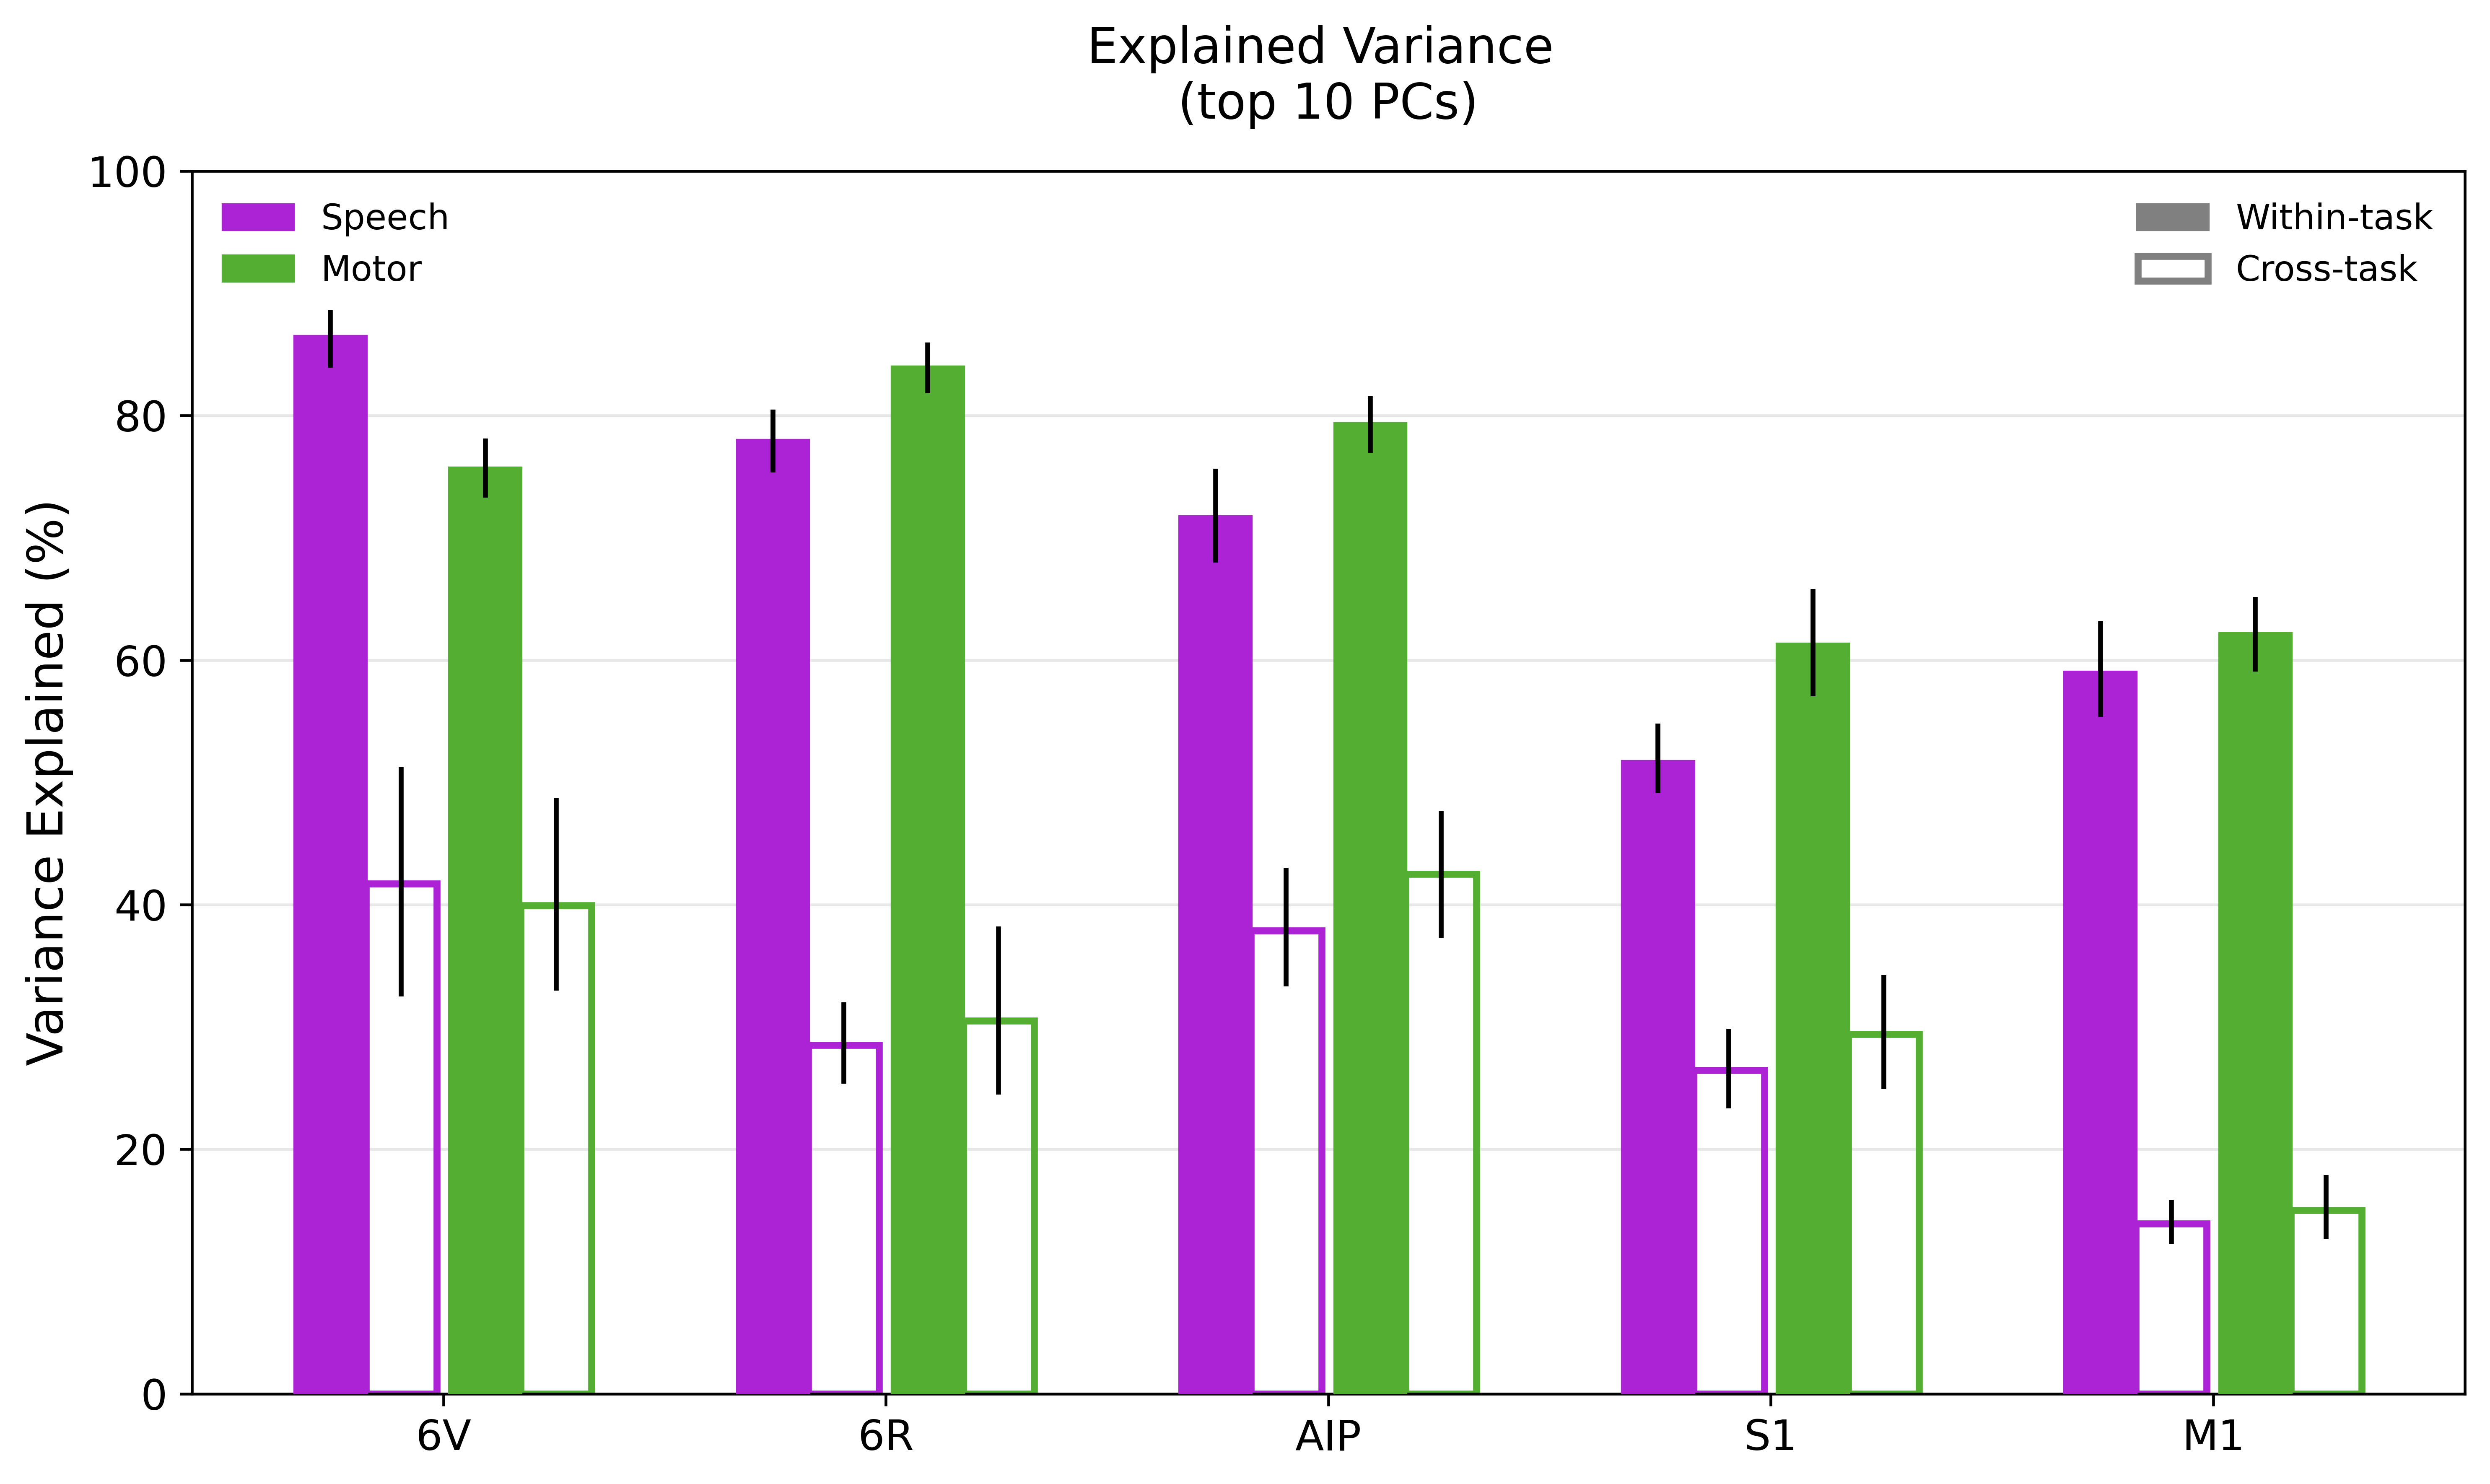

In [57]:
fig, summary = plot_topk_variance_explained(
    var_source=PCA_projections,
    arrays=["6V", "6R","AIP","S1","M1"],
    k=10,
    show_ci=True)        # uses bootstrap percentiles

# save_figure(fig_handle=fig, fig_name=f"cummulative_variance_explained", fmt="svg", dpi=500)

OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"cummulative_variance_explained", fmt="svg", dpi=500)


### Plot alignment indexes as bar charts

In [40]:
# updated version
def plot_alignment_vs_baseline(
    align_source,
    arrays=None,
    dpi=600,
    fontsize=14,
    ylim=(0, 1),
    title="Cross-Task Subspace Alignment",
    ci=(2.5, 97.5),
    center="mean",
    show_empirical_ci=True,
    show_baseline_ci=True,
    separator_color="black",
    separator_linewidth=3,
    combine_directions=False,
    array_colors=None):
    """
    Plots empirical vs baseline alignment indices for each array and direction.
    Optionally combines directions (speech→grasp and grasp→speech) into one bar per array.

    Parameters
    ----------
    align_source : dict
        Alignment results of form {"per_array": {array: [boot_dicts...]}}
    arrays : list
        List of arrays to include. Defaults to all in align_source["per_array"].
    combine_directions : bool
        If True, combines both directions per array (mean alignment).
        Then plots only one empirical and one baseline bar per array.
    array_colors : dict or None
        If combine_directions=True, maps array name → color hex.
        Baseline bars use same color with alpha=0.25.
    """

    from matplotlib.patches import Patch
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    PAIRS = ("motor→speech", "speech→motor")
    COLORS = {"motor→speech": "#AC22D5", "speech→motor": "#53AE32"}
    lo_p, hi_p = ci
    cfun = np.nanmedian if center == "median" else np.nanmean

    def _nanperc(x):
        x = np.asarray(x, float)
        return (np.nan, np.nan) if ~np.isfinite(x).any() else tuple(np.nanpercentile(x, [lo_p, hi_p]))

    def _fmt_pm(val, lo, hi):
        if np.isfinite(lo) and np.isfinite(hi):
            half = max(val - lo, hi - val)
            return f"{val:.3f} ± {half:.3f}"
        return f"{val:.3f}"

    def _fmt_range(val, lo, hi):
        if np.isfinite(lo) and np.isfinite(hi):
            return f"{val:.3f} [{lo:.3f}, {hi:.3f}]"
        return f"{val:.3f}"

    perm_test = {}

    per = align_source["per_array"]
    if arrays is None:
        arrays = list(per.keys())

    rows = []
    for a in arrays:
        boots = per[a] if isinstance(per[a], list) else [per[a]]
        em_m2s = [float(b["alignment"]["A_motor_to_speech"]) for b in boots]
        em_s2m = [float(b["alignment"]["A_speech_to_motor"]) for b in boots]
        ba_m2s = [float(b["alignment"]["baseline_A_motor_to_speech"]) for b in boots]
        ba_s2m = [float(b["alignment"]["baseline_A_speech_to_motor"]) for b in boots]

        # permutation test
        perm_test[(str(a), "speech→motor")] = permutation_test(em_s2m, ba_s2m, n_perm=10000)
        perm_test[(str(a), "motor→speech")] = permutation_test(em_m2s, ba_m2s, n_perm=10000)

        if combine_directions:
            # combine both directions for each kind
            em_comb = np.nanmean([em_m2s, em_s2m], axis=0)
            ba_comb = np.nanmean([ba_m2s, ba_s2m], axis=0)
            for pair, arr in [("combined", em_comb), ("combined_baseline", ba_comb)]:
                kind = "empirical" if "baseline" not in pair else "baseline"
                c = float(cfun(arr))
                lo, hi = _nanperc(arr)
                rows.append(dict(array=str(a), pair="combined", kind=kind, center=c, lo=float(lo), hi=float(hi)))
        else:
            # separate directions
            for pair, arr in [("motor→speech", em_m2s), ("speech→motor", em_s2m)]:
                c = float(cfun(arr))
                lo, hi = _nanperc(arr)
                rows.append(dict(array=str(a), pair=pair, kind="empirical", center=c, lo=float(lo), hi=float(hi)))
            for pair, arr in [("motor→speech", ba_m2s), ("speech→motor", ba_s2m)]:
                c = float(cfun(arr))
                lo, hi = _nanperc(arr)
                rows.append(dict(array=str(a), pair=pair, kind="baseline", center=c, lo=float(lo), hi=float(hi)))

    summary = pd.DataFrame(rows)
    summary["array"] = pd.Categorical(summary["array"], categories=arrays, ordered=True)

    # ---- Plot ----
    arrays_order = summary["array"].cat.categories.tolist()
    n = len(arrays_order)
    fig, ax = plt.subplots(figsize=(n * 2.2, 6), dpi=dpi)

    x = np.arange(n)
    barw, sep = 0.16, 0.35

    if combine_directions:
        for i, a in enumerate(arrays_order):
            sub = summary[summary["array"] == a]
            col = array_colors[a] if (array_colors and a in array_colors) else "#999999"
            e = sub[sub["kind"] == "empirical"].iloc[0]
            b = sub[sub["kind"] == "baseline"].iloc[0]

            # empirical
            ax.bar(x[i] - barw / 2, e.center, width=barw, color=col, edgecolor=col, zorder=3)
            if show_empirical_ci and np.isfinite(e.lo) and np.isfinite(e.hi):
                ax.errorbar(
                    x[i] - barw / 2, e.center,
                    yerr=[[e.center - e.lo], [e.hi - e.center]],
                    fmt="none", ecolor="black", elinewidth=1.4, capsize=0, zorder=4,
                )

            # vertical separator
            # ax.vlines(x[i], *ylim, color=separator_color, linewidth=separator_linewidth, zorder=1, alpha=0.8)

            # baseline
            ax.bar(x[i] + barw / 2, b.center, width=barw, color=col, alpha=0.25, edgecolor="none", zorder=2)
            if show_baseline_ci and np.isfinite(b.lo) and np.isfinite(b.hi):
                ax.errorbar(
                    x[i] + barw / 2, b.center,
                    yerr=[[b.center - b.lo], [b.hi - b.center]],
                    fmt="none", ecolor="black", elinewidth=1.4, capsize=0, zorder=4,
                )
    else:
        # separate direction plots (original behavior)
        xoff = {"motor→speech": -sep / 2, "speech→motor": +sep / 2}
        for i, a in enumerate(arrays_order):
            sub = summary[summary["array"] == a]
            for pair in PAIRS:
                col = COLORS[pair]
                xc = x[i] + xoff[pair]

                e = sub[(sub["pair"] == pair) & (sub["kind"] == "empirical")].iloc[0]
                b = sub[(sub["pair"] == pair) & (sub["kind"] == "baseline")].iloc[0]

                ax.bar(xc - barw / 2, e.center, width=barw, color=col, edgecolor=col, zorder=3)
                if show_empirical_ci and np.isfinite(e.lo) and np.isfinite(e.hi):
                    ax.errorbar(xc - barw / 2, e.center,
                                yerr=[[e.center - e.lo], [e.hi - e.center]],
                                fmt="none", ecolor="black", elinewidth=1.4, capsize=0, zorder=4)

                # ax.vlines(xc, *ylim, color=separator_color, linewidth=separator_linewidth, zorder=1, alpha=0.8)

                ax.bar(xc + barw / 2, b.center, width=barw, color=col, alpha=0.25, edgecolor="none", zorder=2)
                if show_baseline_ci and np.isfinite(b.lo) and np.isfinite(b.hi):
                    ax.errorbar(xc + barw / 2, b.center,
                                yerr=[[b.center - b.lo], [b.hi - b.center]],
                                fmt="none", ecolor="black", elinewidth=1.4, capsize=0, zorder=4)

    # ---- Formatting ----
    ax.set_ylim(*ylim)
    ax.set_xticks(x)
    ax.set_xticklabels(arrays_order, fontsize=fontsize)
    ax.set_ylabel("Alignment Index", fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize + 2, pad=10)
    ax.grid(axis="y", alpha=0.3, zorder=0)
    ax.tick_params(labelsize=fontsize - 2)

    if not combine_directions:
        pair_handles = [Patch(facecolor=COLORS[p], edgecolor=COLORS[p], label=p) for p in PAIRS]
        leg1 = ax.legend(handles=pair_handles, frameon=False, fontsize=fontsize - 6, loc="upper left")
        style_handles = [
            Patch(facecolor="gray", edgecolor="gray", label="Empirical"),
            Patch(facecolor="lightgray", edgecolor="none", linewidth=2, label="Chance"),
        ]
        ax.add_artist(leg1)
        ax.legend(handles=style_handles, frameon=False, fontsize=fontsize - 6, loc="upper right")
    else:
        style_handles = [
            Patch(facecolor="gray", edgecolor="gray", label="Empirical"),
            Patch(facecolor="lightgray", edgecolor="none", linewidth=2, label="Chance"),
        ]
        ax.legend(handles=style_handles, frameon=False, fontsize=fontsize - 6, loc="upper right")

    fig.tight_layout()
    plt.show()

    # ---- Print permutation test results ----
    print("\n=== Permutation Test Results (empirical > baseline) ===")
    if combine_directions:
        for a in arrays_order:
            # combine both direction results’ p-values if they exist
            m2s = perm_test.get((a, "motor→speech"), {})
            s2m = perm_test.get((a, "speech→motor"), {})
            pvals = []
            if "p_value" in m2s: pvals.append(m2s["p_value"])
            if "p_value" in s2m: pvals.append(s2m["p_value"])

            if len(pvals) > 0:
                mean_p = np.nanmean(pvals)
                print(f"  {a:>6s} | mean p = {mean_p:.5f} | (motor→speech={m2s.get('p_value', np.nan):.5f}, speech→motor={s2m.get('p_value', np.nan):.5f})")
            else:
                print(f"  {a:>6s} | No permutation results found.")
    else:
        for a in arrays_order:
            for pair in ["motor→speech", "speech→motor"]:
                res = perm_test.get((a, pair))
                if res is not None:
                    print(f"  {a:>6s} | {pair:13s} | Δ = {res['obs_diff']:.5f} | p = {res['p_value']:.5f}")
                else:
                    print(f"  {a:>6s} | {pair:13s} | No permutation result available.")

    return fig, summary, perm_test


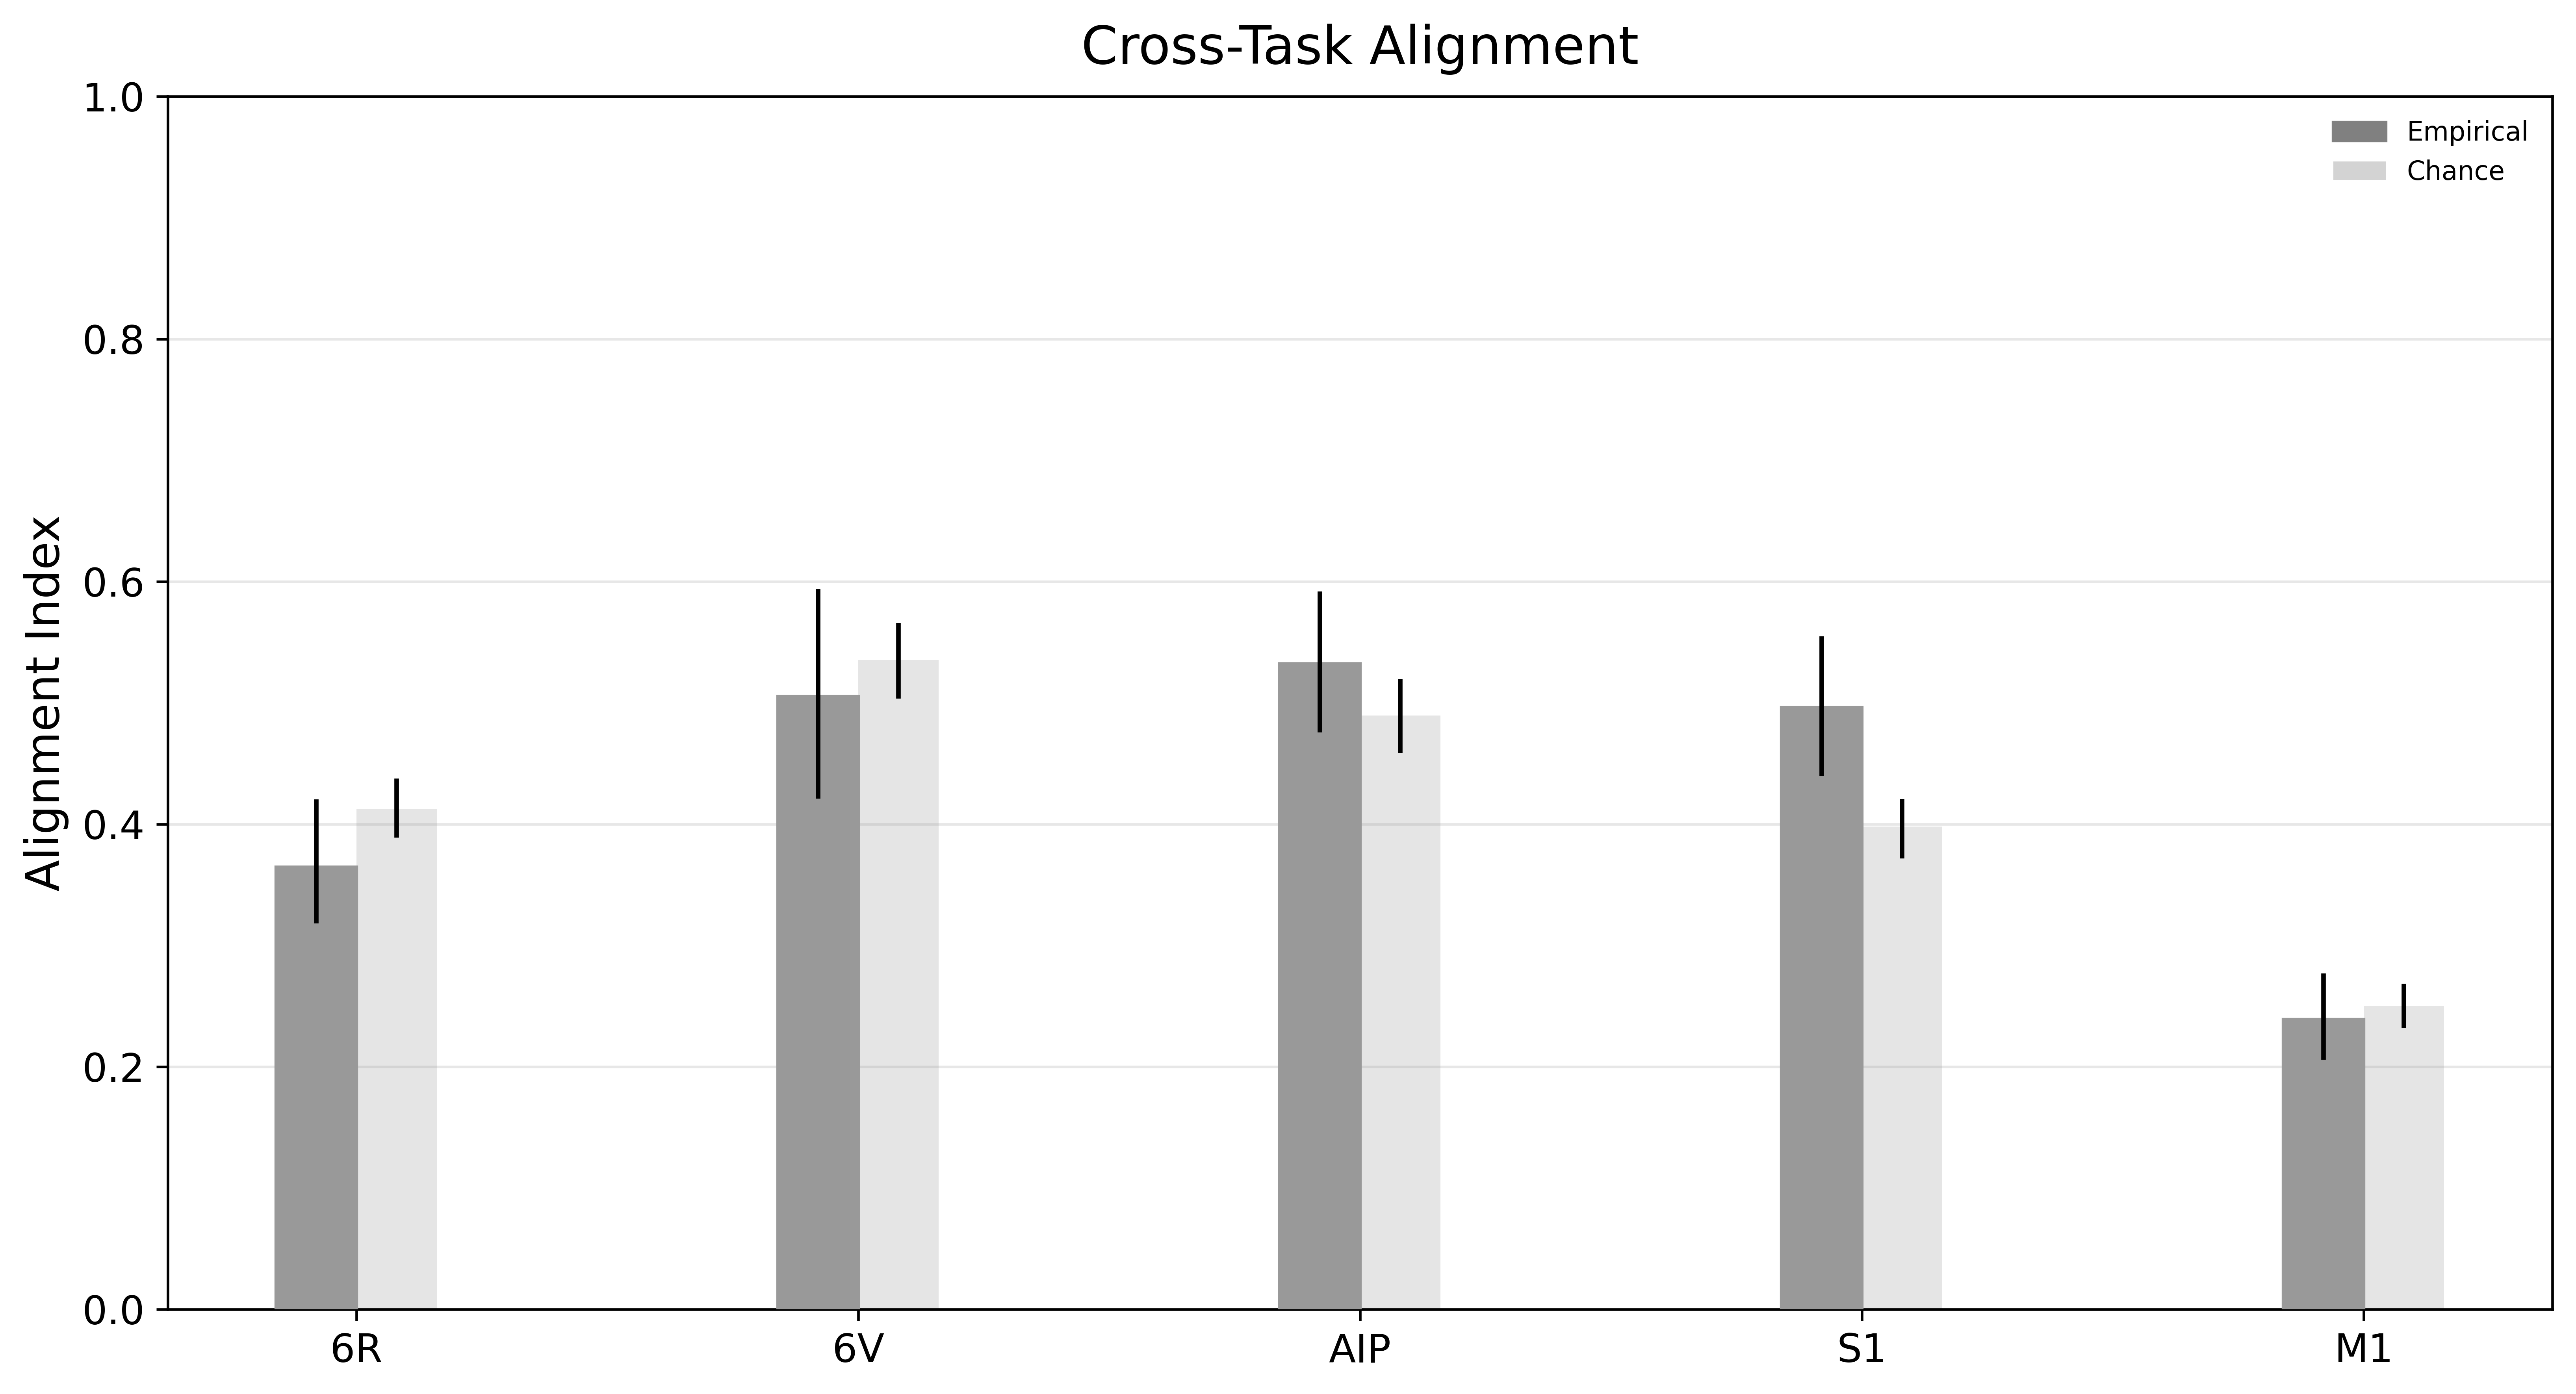


=== Permutation Test Results (empirical > baseline) ===
      6R | mean p = 0.00010 | (motor→speech=0.00010, speech→motor=0.00010)
      6V | mean p = 0.00010 | (motor→speech=0.00010, speech→motor=0.00010)
     AIP | mean p = 0.00010 | (motor→speech=0.00010, speech→motor=0.00010)
      S1 | mean p = 0.00010 | (motor→speech=0.00010, speech→motor=0.00010)
      M1 | mean p = 0.00010 | (motor→speech=0.00010, speech→motor=0.00010)


In [58]:
# fig, summary, perm_test = plot_alignment_vs_baseline(PCA_projections, fontsize=18)

# save_figure(fig_handle=fig, fig_name=f"alignment_indexes", fmt="svg", dpi=500)

array_colors = {"6R": "#1be7ff", "6V": "#6eeb83","AIP":"#e4ff1a","S1":"#ff5714","M1":"#e8aa14"}
arrays = ['6R','6V','AIP','S1','M1']
fig, summary, perm_test = plot_alignment_vs_baseline(
    PCA_projections,
    arrays=arrays,
    combine_directions=True,
    array_colors=None,
    ylim=(0, 1),
    title="Cross-Task Alignment")

OUTPUT_DIR = "/content/drive/MyDrive/ML Projects/RP2_Dual Speech and Motor Representation/Data/Figures2_All_Arrays"

save_figure(fig_handle=fig, base_dir=OUTPUT_DIR, fig_name=f"alignment_indexes", fmt="svg", dpi=500)


In [59]:
# ================================================
# Stats to assess difference between empirical and null alignment indexes
# ================================================
import numpy as np
from scipy.stats import ttest_rel, t

def mean_diff_ci(diffs, alpha=0.05):
    """
    Return (mean_diff, ci_lo, ci_hi) for paired differences.
    """
    n = diffs.size
    md = np.mean(diffs)
    sd = np.std(diffs, ddof=1)
    se = sd / np.sqrt(n)
    tcrit = t.ppf(1 - alpha / 2, df=n - 1)
    ci_lo, ci_hi = md - tcrit * se, md + tcrit * se
    return md, ci_lo, ci_hi


# ===========================================================
# Config
# ===========================================================
combine_directions = True   # <-- set to False for per-direction results
alpha = 0.05
arrays = ['6V', '6R', 'AIP', 'S1', 'M1']


# ===========================================================
# Loop over arrays
# ===========================================================
for array in arrays:
    boots = PCA_projections['per_array'][array]

    speech2motor_empirical = np.array([float(b["alignment"]["A_speech_to_motor"]) for b in boots])
    speech2motor_baseline  = np.array([float(b["alignment"]["baseline_A_speech_to_motor"]) for b in boots])

    motor2speech_empirical = np.array([float(b["alignment"]["A_motor_to_speech"]) for b in boots])
    motor2speech_baseline  = np.array([float(b["alignment"]["baseline_A_motor_to_speech"]) for b in boots])

    print(f"\n\n######################## {array} ########################")

    # ---------- helper for t-test with automatic direction ----------
    def run_test(empirical, baseline, label):
        diffs = empirical - baseline  # positive if empirical > baseline
        md, ci_lo, ci_hi = mean_diff_ci(diffs)
        half = max(md - ci_lo, ci_hi - md)

        # choose test direction automatically
        alternative = "greater" if md > 0 else "less"
        t_stat, p_val = ttest_rel(empirical, baseline, alternative=alternative)

        # interpretation
        if p_val < alpha:
            if md > 0:
                interp = f"→ Empirical alignment is significantly greater than baseline (p = {p_val:.4g})."
            else:
                interp = f"→ Empirical alignment is significantly lower than baseline (p = {p_val:.4g})."
        else:
            interp = f"→ No significant difference between empirical and baseline (p = {p_val:.4g})."

        # report
        print(f"\n--------------- {label} --------------")
        print(f"paired t-test ({alternative}): Δ̄ = {md:.3f} ± {half:.3f}, "
              f"t = {t_stat:.3f}, p = {p_val:.4g}")
        print(interp)

    # =====================================================
    # Combined or per-direction analyses
    # =====================================================
    if combine_directions:
        # Combine directions by averaging per bootstrap
        combined_empirical = np.nanmean([speech2motor_empirical, motor2speech_empirical], axis=0)
        combined_baseline  = np.nanmean([speech2motor_baseline, motor2speech_baseline], axis=0)
        run_test(combined_empirical, combined_baseline, "Combined Directions")

    else:
        run_test(speech2motor_empirical, speech2motor_baseline, "Speech → Motor")
        run_test(motor2speech_empirical, motor2speech_baseline, "Motor → Speech")




######################## 6V ########################

--------------- Combined Directions --------------
paired t-test (less): Δ̄ = -0.030 ± 0.002, t = -28.551, p = 7.085e-132
→ Empirical alignment is significantly lower than baseline (p = 7.085e-132).


######################## 6R ########################

--------------- Combined Directions --------------
paired t-test (less): Δ̄ = -0.048 ± 0.001, t = -80.720, p = 0
→ Empirical alignment is significantly lower than baseline (p = 0).


######################## AIP ########################

--------------- Combined Directions --------------
paired t-test (greater): Δ̄ = 0.042 ± 0.001, t = 73.300, p = 0
→ Empirical alignment is significantly greater than baseline (p = 0).


######################## S1 ########################

--------------- Combined Directions --------------
paired t-test (greater): Δ̄ = 0.098 ± 0.001, t = 154.488, p = 0
→ Empirical alignment is significantly greater than baseline (p = 0).


########################

### Plot alignment indexes as kde distributions

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

PAIRS  = ("motor→speech", "speech→motor")
COLORS = {"motor→speech": "#AC22D5", "speech→motor": "#53AE32"}  # task colors

def plot_align_idx_distributions(PCA_projections, arrays=('6V','6R'),
                                 use_hist=False, bins=30, dpi=500):
    """
    Plot empirical vs baseline bootstrap distributions for both pairs
    (motor→speech, speech→motor) and both arrays (e.g., 6V, 6R),
    stacked vertically in a 4×1 grid with shared x/y axes.

    Parameters
    ----------
    PCA_projections : dict
        Nested dict with bootstrap entries under ['per_array'][array].
    arrays : sequence of str
        Arrays to plot (default = ['6V','6R']).
    use_hist : bool
        If True, draw histograms; else KDE curves.
    bins : int
        Number of bins for histograms (ignored if use_hist=False).
    """
    keys = {
        "motor→speech": "A_motor_to_speech",
        "speech→motor": "A_speech_to_motor",
    }

    fig, axes = plt.subplots(len(arrays) * len(PAIRS), 1,
                             figsize=(6,4*len(arrays)), dpi=dpi,
                             sharex=True, sharey=True)

    axes = np.atleast_1d(axes).ravel()

    plot_idx = 0
    for arr in arrays:
        boots = PCA_projections["per_array"][arr]

        for pair in PAIRS:
            ax = axes[plot_idx]
            plot_idx += 1

            key_ = keys[pair]

            emp_raw  = np.array([float(b["alignment"][key_]) for b in boots])
            # base_raw = np.array([float(b["alignment"]["baseline"][base_key]) for b in boots])
            base_raw = np.array([float(b["alignment"]["baseline_" + key_]) for b in boots])

            empirical = emp_raw[np.isfinite(emp_raw)]
            baseline  = base_raw[np.isfinite(base_raw)]

            if use_hist:
                # Shared bin edges for consistent comparison
                lo = 0
                hi = 1
                edges = np.linspace(lo, hi, bins + 1)

                ax.hist(empirical, bins=edges, alpha=0.45, density=True,
                        color=COLORS[pair], label="Empirical", edgecolor="white", linewidth=0.5)
                ax.hist(baseline,  bins=edges, alpha=0.45, density=True,
                        color="gray", label="Baseline", edgecolor="white", linewidth=0.5)
            else:
                sns.kdeplot(empirical, fill=True, color=COLORS[pair],
                            alpha=0.45, lw=2, label="Empirical", ax=ax)
                sns.kdeplot(baseline,  fill=True, color="gray",
                            alpha=0.45, lw=2, label="Baseline", ax=ax)

            # Means as vertical dashed lines
            if empirical.size:
                ax.axvline(np.mean(empirical), color=COLORS[pair], linestyle="--", lw=1.5)
            if baseline.size:
                ax.axvline(np.mean(baseline), color="gray", linestyle="--", lw=1.5)

            # Titles
            ax.set_title(f"{arr} | {pair}", fontsize=12)

            # Remove spines except bottom one
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if plot_idx < len(arrays) * len(PAIRS):  # not the bottom plot
                ax.spines['bottom'].set_visible(False)
                ax.set_xlabel("")
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            else:
                ax.set_xlabel("Alignment Index", fontsize=12)

            ax.set_ylabel("Density")

            ax.set_xlim(0.1, .7)
            ax.legend(frameon=False, fontsize=8, loc="upper right")

    fig.tight_layout()
    return fig, axes


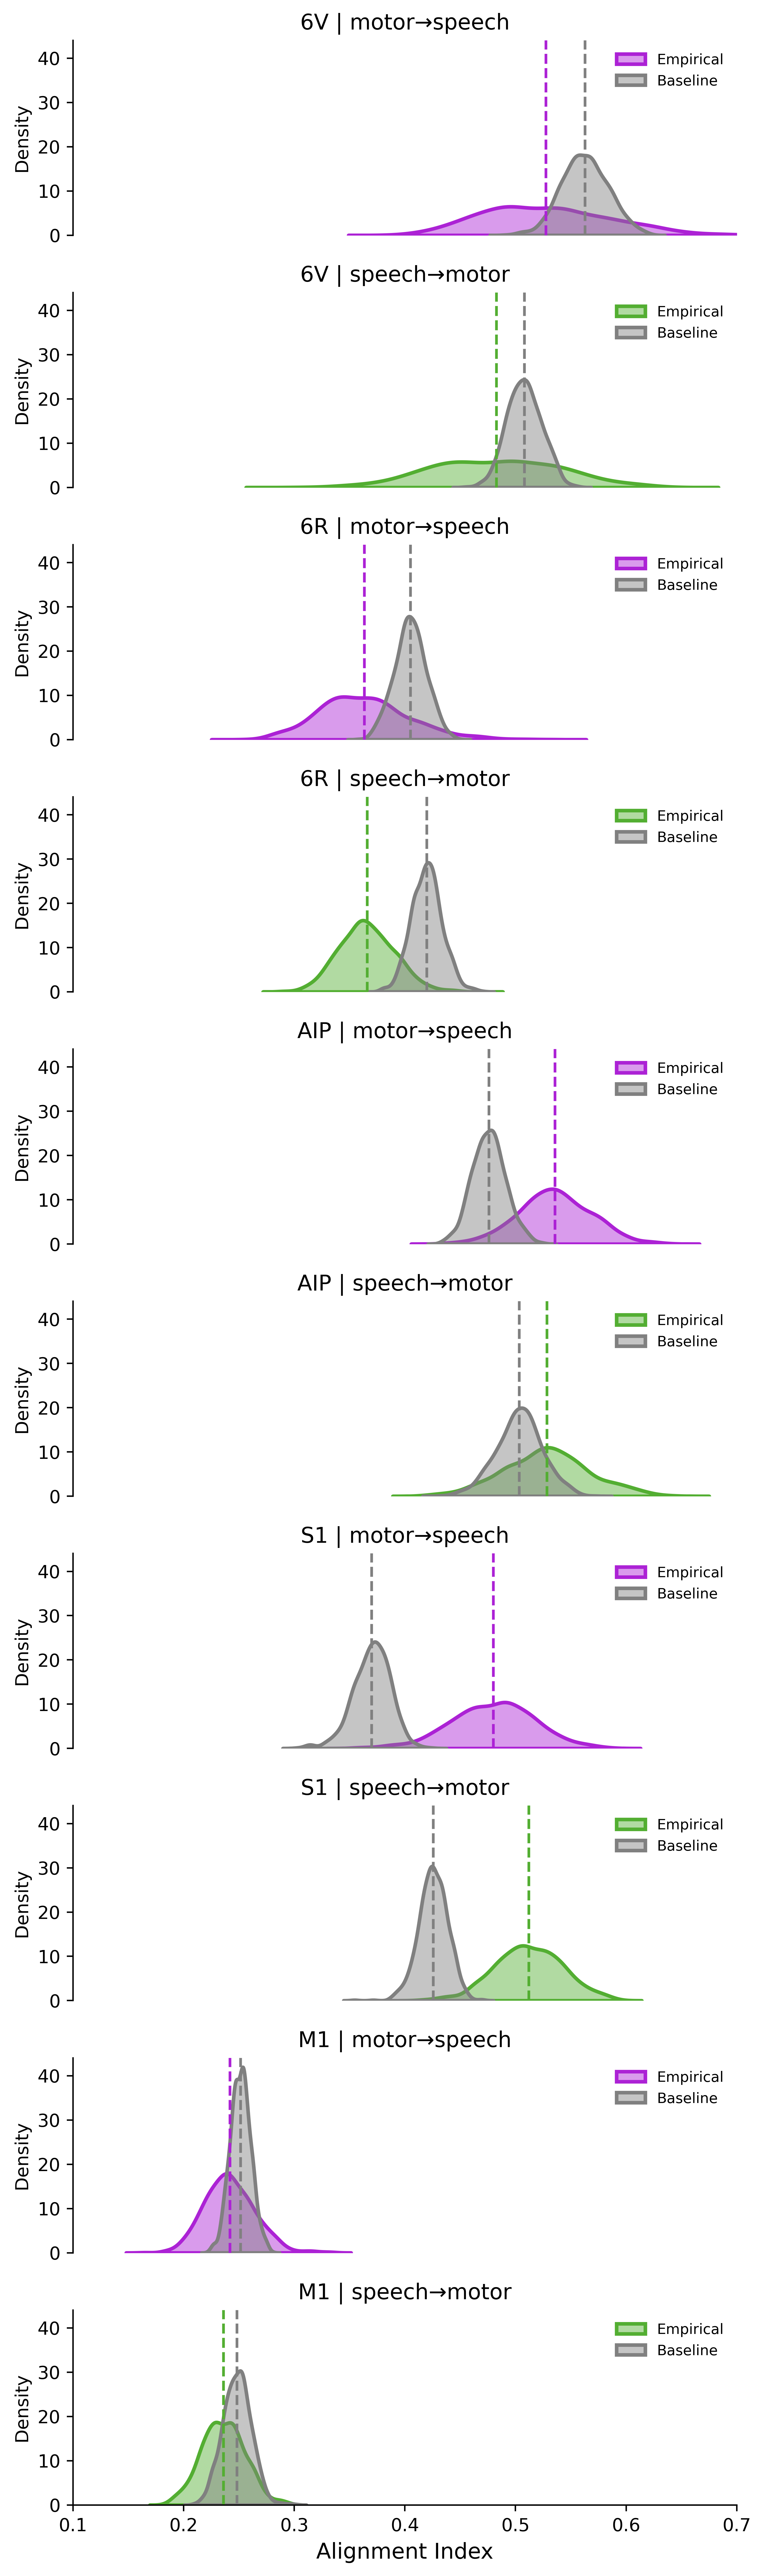

In [27]:
arrays = ['6V','6R','AIP','S1','M1']
fig, axes = plot_align_idx_distributions(PCA_projections, arrays=arrays,use_hist=False)
plt.show()
